In [1]:
# !pip3 install pyarrow
# !pip3 install lightgbm
# !pip3 install optuna

In [2]:
import pandas as pd
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

In [3]:
def preprocess(df, year):
    df[['Env', 'Hybrid']] = df['id'].str.split(':', expand=True)
    df['Env'] += "_" + str(year)
    df = df.drop('id', axis=1).set_index(['Env', 'Hybrid'])
    return df

In [4]:
%%time

ytrain = pd.read_csv('../output/ytrain.csv').set_index(['Env', 'Hybrid'])
xtrain = pd.read_parquet('../output/kronecker_epi_AD_train.parquet')
xtrain = preprocess(xtrain, year=2020)
xtrain = xtrain.merge(ytrain, on=['Env', 'Hybrid'], how='inner')
ytrain = xtrain['Yield_Mg_ha']
del xtrain['Yield_Mg_ha']

yval = pd.read_csv('../output/yval.csv').set_index(['Env', 'Hybrid'])
xval = pd.read_parquet('../output/kronecker_epi_AD_val.parquet')
xval = preprocess(xval, year=2021)
xval = xval.merge(yval, on=['Env', 'Hybrid'], how='inner')
yval = xval['Yield_Mg_ha']
del xval['Yield_Mg_ha']

CPU times: user 14min 18s, sys: 2min 57s, total: 17min 16s
Wall time: 17min 24s


In [5]:
xtrain

weather_station_lat.2369.DK3IIH6  \
Env       Hybrid                                                
DEH1_2020 B14A/H95                                  -0.001324   
          B14A/MO17                                 -0.058384   
          B14A/OH43                                 -0.014650   
          B37/H95                                   -0.131880   
          B37/MO17                                  -0.239823   
...                                                       ...   
WIH3_2020 W10004_1123/PHP02                          0.343808   
          W10004_1140/PHP02                          0.364190   
          W10004_1143/PHP02                          0.132302   
          W10004_1146/PHP02                          0.553130   
          W10004_1156/PHP02                          0.597037   

                             weather_station_lat.2369.PHN82  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                -0.011488   
          B14A/MO17                               -0.070036   
          B14A/OH43                               -0.022739   
          B37/H95                                 -0.206330   
          B37/MO17                                -0.226595   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                        0.663912   
          W10004_1140/PHP02                        0.834954   
          W10004_1143/PHP02                        0.184552   
          W10004_1146/PHP02                        1.174040   
          W10004_1156/PHP02                        1.189275   

                             weather_station_lat.2369.PHZ51  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                -0.028589   
          B14A/MO17                               -0.052512   
          B14A/OH43                               -0.040454   
          B37/H95                                 -0.154437   
          B37/MO17                                -0.177987   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                       -0.142003   
          W10004_1140/PHP02                       -0.234557   
          W10004_1143/PHP02                       -0.307063   
          W10004_1146/PHP02                       -0.213704   
          W10004_1156/PHP02                       -0.255493   

                             weather_station_lat.2FACC.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                    0.005221   
          B14A/MO17                                  -0.006701   
          B14A/OH43                                   0.000288   
          B37/H95                                     0.021271   
          B37/MO17                                    0.051101   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                          -0.013953   
          W10004_1140/PHP02                          -0.084683   
          W10004_1143/PHP02                          -0.438864   
          W10004_1146/PHP02                          -0.175162   
          W10004_1156/PHP02                          -0.240217   

                             weather_station_lat.4N506.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                    0.005240   
          B14A/MO17                                  -0.002555   
          B14A/OH43                                   0.007726   
          B37/H95                                    -0.057384   
          B37/MO17                                   -0.130275   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                           0.264056   
          W10004_1140/PHP02                           0.388607   
          W10004_1143/PH

### Training

In [6]:
# %%time

# NCOLS = xtrain.shape[1]
# print('features:', NCOLS)

# best_params = {'feature_fraction': 0.4953070809776986, 'num_leaves': 247, 
#                'bagging_fraction': 0.9866458243098336, 'lambda_l1': 3.680660098838679, 
#                'lambda_l2': 1.1632141265265e-06, 'n_estimators': 232, 'max_depth': 3}
# model = lgbm.LGBMRegressor(random_state=42, **best_params)
# model.fit(xtrain.iloc[:, :NCOLS], ytrain)

# # predict
# ypred = model.predict(xval.iloc[:, :NCOLS])

# # validate
# df_eval = pd.DataFrame()
# df_eval['Env'] = xval.index.get_level_values(0)
# df_eval['ytrue'] = list(yval)
# df_eval['ypred'] = ypred
# rmse_per_group = df_eval.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
# print(rmse_per_group)

# rmse = sum(rmse_per_group) / len(rmse_per_group)
# print('RMSE:', rmse)

In [7]:
# print(r2_score(df_eval['ytrue'], df_eval['ypred']))
# df_eval.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [8]:
from sklearn.decomposition import TruncatedSVD

In [9]:
%%time

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(xtrain)
print(svd.explained_variance_ratio_.sum())

0.8565338780416973
CPU times: user 5min 19s, sys: 8.93 s, total: 5min 28s
Wall time: 5min 30s


In [10]:
%%time

xtrain_svd = pd.DataFrame(svd.transform(xtrain), index=xtrain.index)
xtrain_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

xval_svd = pd.DataFrame(svd.transform(xval), index=xval.index)
xval_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

CPU times: user 57.5 s, sys: 2.32 ms, total: 57.5 s
Wall time: 57.7 s


In [11]:
xtrain_lag = pd.read_csv('../output/xtrain.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xval_lag = pd.read_csv('../output/xval.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xtrain_svd = xtrain_svd.merge(xtrain_lag, on=['Env', 'Hybrid'], how='inner')
xval_svd = xval_svd.merge(xval_lag, on=['Env', 'Hybrid'], how='inner')

In [12]:
xtrain_svd

kron_svd0    kron_svd1    kron_svd2   kron_svd3  \
Env       Hybrid                                                                
DEH1_2020 B14A/H95           -13.306898   -17.692346    23.508117    4.787140   
          B14A/MO17           48.369853  -101.622840   124.501834   -8.918544   
          B14A/OH43          -43.075964   -65.518135    93.338320   14.946720   
          B37/H95            -67.526587   -96.834271    11.913213   27.952412   
          B37/MO17             5.004218  -220.946922   135.106205   14.594839   
...                                 ...          ...          ...         ...   
WIH3_2020 W10004_1123/PHP02 -630.101579  4798.204550  1049.988184 -179.306386   
          W10004_1140/PHP02 -911.926669  5647.661467  1204.260096 -251.548602   
          W10004_1143/PHP02 -840.402471  4857.804630  1039.503292 -227.376368   
          W10004_1146/PHP02 -920.217999  6038.879716  1304.580703 -255.473712   
          W10004_1156/PHP02 -811.805383  4710.240134  1010.652162 -225.332372   

                              kron_svd4    kron_svd5    kron_svd6  \
Env       Hybrid                                                    
DEH1_2020 B14A/H95           -17.908147     0.195391    -1.006413   
          B14A/MO17          -10.619824     0.842840    -1.027035   
          B14A/OH43          -38.995133    -0.006202    -1.601816   
          B37/H95           -240.648747     1.720037    -8.341005   
          B37/MO17          -357.191556     4.004896   -12.924350   
...                                 ...          ...          ...   
WIH3_2020 W10004_1123/PHP02   46.239205 -1243.265358  3776.728947   
          W10004_1140/PHP02 -141.318714 -1482.562488  4446.032407   
          W10004_1143/PHP02 -338.099677 -1279.554849  3820.275876   
          W10004_1146/PHP02 -107.027745 -1579.158289  4754.743805   
          W10004_1156/PHP02 -121.552754 -1242.199635  3711.443571   

                               kron_svd7    kron_svd8   kron_svd9  ...  \
Env       Hybrid                                                   ...   
DEH1_2020 B14A/H95            -36.307020    29.971581  -38.558518  ...   
          B14A/MO17          -126.874720   111.584255 -198.858767  ...   
          B14A/OH43           -55.120694    38.717182  -65.743770  ...   
          B37/H95             347.097972   163.171348  422.441838  ...   
          B37/MO17            475.318953   389.203521  459.483207  ...   
...                                  ...          ...         ...  ...   
WIH3_2020 W10004_1123/PHP02 -1498.179936  1938.738696 -821.771619  ...   
          W10004_1140/PHP02   270.023750  -478.001941 -381.553330  ...   
          W10004_1143/PHP02   878.150287  -511.939850  469.067903  ...   
          W10004_1146/PHP02  -410.321670   399.702435  -29.224612  ...   
          W10004_1156/PHP02  -484.489390   386.059393 -100.590770  ...   

                             kron_svd96  kron_svd97  kron_svd98  kron_svd99  \
Env       Hybrid                                                              
DEH1_2020 B14A/H95            40.942873   63.940229   59.343182  104.029160   
          B14A/MO17         -152.199455 -131.011477  294.164696  126.188811   
          B14A/OH43           52.375963  -16.459826  -21.788785  -63.418462   
          B37/H95             40.780146   19.242296   45.825016    9.916170   
          B37/MO17            30.900435    1.752091   -6.622902  -43.976526   
...                                 ...         ...         ...         ...   
WIH3_2020 W10004_1123/PHP02 -333.751066  -93.749628 -160.656311 -602.183248   
          W10004_1140/PHP02   61.582849   78.299133   14.953387   56.808266   
          W10004_1143/PHP02 -296.207063   -9.673533  -77.176135 -158.221995   
          W10004_1146/PHP02   51.105073  228.121669 -133.629769 -110.558247   
          W10004_1156/PHP02  163.891395  189.147958  -74.840392  -11.309116   

                             mean_yield_lag_2  min_yield_lag_2  \
Env       Hybrid     

In [13]:
import optuna

In [14]:
def objective(trial):
    """
    https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
    """
    params = {

#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'deterministic': True,
        'random_state': 42
    }
    
    model2 = lgbm.LGBMRegressor(**params)
    model2.fit(xtrain_svd, ytrain)

    # predict
    ypred2 = model2.predict(xval_svd)

    # validate
    df_eval2 = pd.DataFrame()
    df_eval2['Env'] = xval_svd.index.get_level_values(0)
    df_eval2['ytrue'] = list(yval)
    df_eval2['ypred'] = ypred2
    rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
    # print(rmse_per_group2)

    rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
    return rmse2


study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_value)

[I 2023-02-01 18:52:45,952] A new study created in memory with name: no-name-48c0cf3c-9de8-4cde-a2be-b38823568d8f


[LightGBM] [Warning] lambda_l1 is set=0.0024430162614261413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024430162614261413
[LightGBM] [Warning] bagging_fraction is set=0.839196365086843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.839196365086843
[LightGBM] [Warning] feature_fraction is set=0.3745401188473625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745401188473625
[LightGBM] [Warning] lambda_l2 is set=2.5361081166471375e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5361081166471375e-07


[I 2023-02-01 18:52:46,337] Trial 0 finished with value: 2.3022401133444097 and parameters: {'feature_fraction': 0.3745401188473625, 'num_leaves': 244, 'bagging_fraction': 0.839196365086843, 'lambda_l1': 0.0024430162614261413, 'lambda_l2': 2.5361081166471375e-07, 'n_estimators': 55, 'max_depth': 2}. Best is trial 0 with value: 2.3022401133444097.


[LightGBM] [Warning] lambda_l1 is set=1.5320059381854043e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5320059381854043e-08
[LightGBM] [Warning] bagging_fraction is set=0.8248435466776274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8248435466776274
[LightGBM] [Warning] feature_fraction is set=0.8661761457749352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661761457749352
[LightGBM] [Warning] lambda_l2 is set=5.360294728728285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.360294728728285


[I 2023-02-01 18:52:47,677] Trial 1 finished with value: 2.247190442382335 and parameters: {'feature_fraction': 0.8661761457749352, 'num_leaves': 155, 'bagging_fraction': 0.8248435466776274, 'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285, 'n_estimators': 252, 'max_depth': 3}. Best is trial 1 with value: 2.247190442382335.


[LightGBM] [Warning] lambda_l1 is set=0.00052821153945323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00052821153945323
[LightGBM] [Warning] bagging_fraction is set=0.5825453457757226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5825453457757226
[LightGBM] [Warning] feature_fraction is set=0.18182496720710062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18182496720710062
[LightGBM] [Warning] lambda_l2 is set=7.71800699380605e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.71800699380605e-05


[I 2023-02-01 18:52:48,239] Trial 2 finished with value: 2.273879877084894 and parameters: {'feature_fraction': 0.18182496720710062, 'num_leaves': 48, 'bagging_fraction': 0.5825453457757226, 'lambda_l1': 0.00052821153945323, 'lambda_l2': 7.71800699380605e-05, 'n_estimators': 94, 'max_depth': 5}. Best is trial 1 with value: 2.247190442382335.


[LightGBM] [Warning] lambda_l1 is set=0.00012724181576752517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012724181576752517
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] feature_fraction is set=0.13949386065204183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13949386065204183
[LightGBM] [Warning] lambda_l2 is set=0.1165691561324743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1165691561324743


[I 2023-02-01 18:52:48,628] Trial 3 finished with value: 2.276094296632952 and parameters: {'feature_fraction': 0.13949386065204183, 'num_leaves': 76, 'bagging_fraction': 0.619817105976215, 'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.1165691561324743, 'n_estimators': 68, 'max_depth': 4}. Best is trial 1 with value: 2.247190442382335.


[LightGBM] [Warning] lambda_l1 is set=3.425445902633376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.425445902633376e-07
[LightGBM] [Warning] bagging_fraction is set=0.764526911140863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.764526911140863
[LightGBM] [Warning] feature_fraction is set=0.5924145688620425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5924145688620425
[LightGBM] [Warning] lambda_l2 is set=3.850031979199519e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.850031979199519e-08


[I 2023-02-01 18:52:50,288] Trial 4 finished with value: 2.295808722035164 and parameters: {'feature_fraction': 0.5924145688620425, 'num_leaves': 13, 'bagging_fraction': 0.764526911140863, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199519e-08, 'n_estimators': 286, 'max_depth': 6}. Best is trial 1 with value: 2.247190442382335.


[LightGBM] [Warning] lambda_l1 is set=0.014391207615728067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014391207615728067
[LightGBM] [Warning] bagging_fraction is set=0.45860326840383037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45860326840383037
[LightGBM] [Warning] feature_fraction is set=0.8083973481164611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8083973481164611
[LightGBM] [Warning] lambda_l2 is set=9.148975058772307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.148975058772307e-05


[I 2023-02-01 18:52:50,845] Trial 5 finished with value: 2.360737084428054 and parameters: {'feature_fraction': 0.8083973481164611, 'num_leaves': 79, 'bagging_fraction': 0.45860326840383037, 'lambda_l1': 0.014391207615728067, 'lambda_l2': 9.148975058772307e-05, 'n_estimators': 45, 'max_depth': 4}. Best is trial 1 with value: 2.247190442382335.


[LightGBM] [Warning] lambda_l1 is set=0.009176996354542699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009176996354542699
[LightGBM] [Warning] bagging_fraction is set=0.5552679889600102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5552679889600102
[LightGBM] [Warning] feature_fraction is set=0.034388521115218396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.034388521115218396
[LightGBM] [Warning] lambda_l2 is set=6.388511557344611e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.388511557344611e-06


[I 2023-02-01 18:52:51,298] Trial 6 finished with value: 2.238138052610682 and parameters: {'feature_fraction': 0.034388521115218396, 'num_leaves': 233, 'bagging_fraction': 0.5552679889600102, 'lambda_l1': 0.009176996354542699, 'lambda_l2': 6.388511557344611e-06, 'n_estimators': 161, 'max_depth': 4}. Best is trial 6 with value: 2.238138052610682.


[LightGBM] [Warning] lambda_l1 is set=2.854239907497756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854239907497756
[LightGBM] [Warning] bagging_fraction is set=0.8650796940166687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8650796940166687
[LightGBM] [Warning] feature_fraction is set=0.18485445552552704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18485445552552704
[LightGBM] [Warning] lambda_l2 is set=1.1309571585271483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1309571585271483


[I 2023-02-01 18:52:52,320] Trial 7 finished with value: 2.255905476161133 and parameters: {'feature_fraction': 0.18485445552552704, 'num_leaves': 249, 'bagging_fraction': 0.8650796940166687, 'lambda_l1': 2.854239907497756, 'lambda_l2': 1.1309571585271483, 'n_estimators': 183, 'max_depth': 6}. Best is trial 6 with value: 2.238138052610682.


[LightGBM] [Warning] lambda_l1 is set=8.471746987003668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.471746987003668e-06
[LightGBM] [Warning] bagging_fraction is set=0.4271363733463229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4271363733463229
[LightGBM] [Warning] feature_fraction is set=0.0884925020519195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0884925020519195
[LightGBM] [Warning] lambda_l2 is set=3.148441347423712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.148441347423712e-05


[I 2023-02-01 18:52:52,819] Trial 8 finished with value: 2.209554994593348 and parameters: {'feature_fraction': 0.0884925020519195, 'num_leaves': 51, 'bagging_fraction': 0.4271363733463229, 'lambda_l1': 8.471746987003668e-06, 'lambda_l2': 3.148441347423712e-05, 'n_estimators': 88, 'max_depth': 6}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=1.8548894229694903e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8548894229694903e-07
[LightGBM] [Warning] bagging_fraction is set=0.7256176498949491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7256176498949491
[LightGBM] [Warning] feature_fraction is set=0.3567533266935893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3567533266935893
[LightGBM] [Warning] lambda_l2 is set=0.16587190283399655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16587190283399655


[I 2023-02-01 18:52:53,321] Trial 9 finished with value: 2.296118966238035 and parameters: {'feature_fraction': 0.3567533266935893, 'num_leaves': 73, 'bagging_fraction': 0.7256176498949491, 'lambda_l1': 1.8548894229694903e-07, 'lambda_l2': 0.16587190283399655, 'n_estimators': 31, 'max_depth': 6}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=1.3232991168593193e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232991168593193e-05
[LightGBM] [Warning] bagging_fraction is set=0.4045283915897759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4045283915897759
[LightGBM] [Warning] feature_fraction is set=0.020652387802087196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.020652387802087196
[LightGBM] [Warning] lambda_l2 is set=0.005764962972197537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005764962972197537


[I 2023-02-01 18:52:53,782] Trial 10 finished with value: 2.261154577105031 and parameters: {'feature_fraction': 0.020652387802087196, 'num_leaves': 143, 'bagging_fraction': 0.4045283915897759, 'lambda_l1': 1.3232991168593193e-05, 'lambda_l2': 0.005764962972197537, 'n_estimators': 120, 'max_depth': 5}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=0.045549901978910304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.045549901978910304
[LightGBM] [Warning] bagging_fraction is set=0.5178281740292456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5178281740292456
[LightGBM] [Warning] feature_fraction is set=0.006383103434000781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.006383103434000781
[LightGBM] [Warning] lambda_l2 is set=3.587017613246042e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.587017613246042e-06


[I 2023-02-01 18:52:54,210] Trial 11 finished with value: 2.337762358934996 and parameters: {'feature_fraction': 0.006383103434000781, 'num_leaves': 191, 'bagging_fraction': 0.5178281740292456, 'lambda_l1': 0.045549901978910304, 'lambda_l2': 3.587017613246042e-06, 'n_estimators': 183, 'max_depth': 3}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=1.5933523153411743e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5933523153411743e-05
[LightGBM] [Warning] bagging_fraction is set=0.5134256426269105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5134256426269105
[LightGBM] [Warning] feature_fraction is set=0.2622713788133536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2622713788133536
[LightGBM] [Warning] lambda_l2 is set=5.0329419692858124e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0329419692858124e-06


[I 2023-02-01 18:52:55,014] Trial 12 finished with value: 2.226995679000023 and parameters: {'feature_fraction': 0.2622713788133536, 'num_leaves': 194, 'bagging_fraction': 0.5134256426269105, 'lambda_l1': 1.5933523153411743e-05, 'lambda_l2': 5.0329419692858124e-06, 'n_estimators': 146, 'max_depth': 5}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=1.3449336957629834e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3449336957629834e-05
[LightGBM] [Warning] bagging_fraction is set=0.41650356569876335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41650356569876335
[LightGBM] [Warning] feature_fraction is set=0.32138132541032255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.32138132541032255
[LightGBM] [Warning] lambda_l2 is set=0.0003611850661894637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003611850661894637


[I 2023-02-01 18:52:55,795] Trial 13 finished with value: 2.2208187843194014 and parameters: {'feature_fraction': 0.32138132541032255, 'num_leaves': 182, 'bagging_fraction': 0.41650356569876335, 'lambda_l1': 1.3449336957629834e-05, 'lambda_l2': 0.0003611850661894637, 'n_estimators': 121, 'max_depth': 5}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=3.7839972839864873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7839972839864873e-06
[LightGBM] [Warning] bagging_fraction is set=0.4011839957803831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4011839957803831
[LightGBM] [Warning] feature_fraction is set=0.5142229231731887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5142229231731887
[LightGBM] [Warning] lambda_l2 is set=0.0017743708155931641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017743708155931641


[I 2023-02-01 18:52:56,719] Trial 14 finished with value: 2.244007782076232 and parameters: {'feature_fraction': 0.5142229231731887, 'num_leaves': 111, 'bagging_fraction': 0.4011839957803831, 'lambda_l1': 3.7839972839864873e-06, 'lambda_l2': 0.0017743708155931641, 'n_estimators': 106, 'max_depth': 5}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=0.00013517330192827957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013517330192827957
[LightGBM] [Warning] bagging_fraction is set=0.9792027676392733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9792027676392733
[LightGBM] [Warning] feature_fraction is set=0.3174406662220687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3174406662220687
[LightGBM] [Warning] lambda_l2 is set=0.0006959354691772952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006959354691772952


[I 2023-02-01 18:52:57,433] Trial 15 finished with value: 2.2290521262649614 and parameters: {'feature_fraction': 0.3174406662220687, 'num_leaves': 5, 'bagging_fraction': 0.9792027676392733, 'lambda_l1': 0.00013517330192827957, 'lambda_l2': 0.0006959354691772952, 'n_estimators': 229, 'max_depth': 6}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=1.190534637958055e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.190534637958055e-06
[LightGBM] [Warning] bagging_fraction is set=0.6133789808633593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6133789808633593
[LightGBM] [Warning] feature_fraction is set=0.4407393167753044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4407393167753044
[LightGBM] [Warning] lambda_l2 is set=0.009035078527798963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009035078527798963


[I 2023-02-01 18:52:57,793] Trial 16 finished with value: 2.337326093941501 and parameters: {'feature_fraction': 0.4407393167753044, 'num_leaves': 177, 'bagging_fraction': 0.6133789808633593, 'lambda_l1': 1.190534637958055e-06, 'lambda_l2': 0.009035078527798963, 'n_estimators': 11, 'max_depth': 5}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=5.704246908470998e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.704246908470998e-06
[LightGBM] [Warning] bagging_fraction is set=0.4727747559252812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4727747559252812
[LightGBM] [Warning] feature_fraction is set=0.24118262174887065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24118262174887065
[LightGBM] [Warning] lambda_l2 is set=0.00018903362535704378, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018903362535704378


[I 2023-02-01 18:52:58,508] Trial 17 finished with value: 2.243530441222903 and parameters: {'feature_fraction': 0.24118262174887065, 'num_leaves': 122, 'bagging_fraction': 0.4727747559252812, 'lambda_l1': 5.704246908470998e-06, 'lambda_l2': 0.00018903362535704378, 'n_estimators': 86, 'max_depth': 6}. Best is trial 8 with value: 2.209554994593348.


[LightGBM] [Warning] lambda_l1 is set=4.635122736264973e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.635122736264973e-05
[LightGBM] [Warning] bagging_fraction is set=0.6515753095328618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6515753095328618
[LightGBM] [Warning] feature_fraction is set=0.0930907509219848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0930907509219848
[LightGBM] [Warning] lambda_l2 is set=3.7978339537142774e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7978339537142774e-05


[I 2023-02-01 18:52:59,006] Trial 18 finished with value: 2.1774043060422548 and parameters: {'feature_fraction': 0.0930907509219848, 'num_leaves': 215, 'bagging_fraction': 0.6515753095328618, 'lambda_l1': 4.635122736264973e-05, 'lambda_l2': 3.7978339537142774e-05, 'n_estimators': 140, 'max_depth': 4}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=0.00011791488644317595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011791488644317595
[LightGBM] [Warning] bagging_fraction is set=0.6582712497421666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6582712497421666
[LightGBM] [Warning] feature_fraction is set=0.09786484880675184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09786484880675184
[LightGBM] [Warning] lambda_l2 is set=1.9378398037972997e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9378398037972997e-05


[I 2023-02-01 18:52:59,508] Trial 19 finished with value: 2.1889825183147673 and parameters: {'feature_fraction': 0.09786484880675184, 'num_leaves': 217, 'bagging_fraction': 0.6582712497421666, 'lambda_l1': 0.00011791488644317595, 'lambda_l2': 1.9378398037972997e-05, 'n_estimators': 199, 'max_depth': 3}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=0.00013358145507530084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00013358145507530084
[LightGBM] [Warning] bagging_fraction is set=0.6558079996564564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6558079996564564
[LightGBM] [Warning] feature_fraction is set=0.1328490844766084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1328490844766084
[LightGBM] [Warning] lambda_l2 is set=6.082414116824283e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.082414116824283e-07


[I 2023-02-01 18:53:00,127] Trial 20 finished with value: 2.220265752692032 and parameters: {'feature_fraction': 0.1328490844766084, 'num_leaves': 216, 'bagging_fraction': 0.6558079996564564, 'lambda_l1': 0.00013358145507530084, 'lambda_l2': 6.082414116824283e-07, 'n_estimators': 220, 'max_depth': 3}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=5.252397189117721e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.252397189117721e-05
[LightGBM] [Warning] bagging_fraction is set=0.680814957850848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.680814957850848
[LightGBM] [Warning] feature_fraction is set=0.09817031464901471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09817031464901471
[LightGBM] [Warning] lambda_l2 is set=4.331577410089601e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.331577410089601e-05


[I 2023-02-01 18:53:00,531] Trial 21 finished with value: 2.259690822766083 and parameters: {'feature_fraction': 0.09817031464901471, 'num_leaves': 211, 'bagging_fraction': 0.680814957850848, 'lambda_l1': 5.252397189117721e-05, 'lambda_l2': 4.331577410089601e-05, 'n_estimators': 151, 'max_depth': 2}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=0.0009300310542926522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009300310542926522
[LightGBM] [Warning] bagging_fraction is set=0.643751693367216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.643751693367216
[LightGBM] [Warning] feature_fraction is set=0.07890750127841697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07890750127841697
[LightGBM] [Warning] lambda_l2 is set=2.3647799067347168e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3647799067347168e-05


[I 2023-02-01 18:53:01,079] Trial 22 finished with value: 2.2195928614889344 and parameters: {'feature_fraction': 0.07890750127841697, 'num_leaves': 158, 'bagging_fraction': 0.643751693367216, 'lambda_l1': 0.0009300310542926522, 'lambda_l2': 2.3647799067347168e-05, 'n_estimators': 187, 'max_depth': 4}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=4.340290398807067e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.340290398807067e-05
[LightGBM] [Warning] bagging_fraction is set=0.5723867017820156, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5723867017820156
[LightGBM] [Warning] feature_fraction is set=0.2132406872795622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2132406872795622
[LightGBM] [Warning] lambda_l2 is set=1.1103378919297998e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1103378919297998e-05


[I 2023-02-01 18:53:01,703] Trial 23 finished with value: 2.2522769014958786 and parameters: {'feature_fraction': 0.2132406872795622, 'num_leaves': 39, 'bagging_fraction': 0.5723867017820156, 'lambda_l1': 4.340290398807067e-05, 'lambda_l2': 1.1103378919297998e-05, 'n_estimators': 213, 'max_depth': 3}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=1.7269547587376826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7269547587376826e-06
[LightGBM] [Warning] bagging_fraction is set=0.6955811176740307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6955811176740307
[LightGBM] [Warning] feature_fraction is set=0.117082353175192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.117082353175192
[LightGBM] [Warning] lambda_l2 is set=2.1654402430244374e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1654402430244374e-06


[I 2023-02-01 18:53:02,208] Trial 24 finished with value: 2.217395289966704 and parameters: {'feature_fraction': 0.117082353175192, 'num_leaves': 100, 'bagging_fraction': 0.6955811176740307, 'lambda_l1': 1.7269547587376826e-06, 'lambda_l2': 2.1654402430244374e-06, 'n_estimators': 135, 'max_depth': 4}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=0.00037924014673116176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037924014673116176
[LightGBM] [Warning] bagging_fraction is set=0.5311160382344413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5311160382344413
[LightGBM] [Warning] feature_fraction is set=0.007258942989757003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007258942989757003
[LightGBM] [Warning] lambda_l2 is set=3.1947969416337e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1947969416337e-05


[I 2023-02-01 18:53:02,698] Trial 25 finished with value: 2.3349806094677907 and parameters: {'feature_fraction': 0.007258942989757003, 'num_leaves': 214, 'bagging_fraction': 0.5311160382344413, 'lambda_l1': 0.00037924014673116176, 'lambda_l2': 3.1947969416337e-05, 'n_estimators': 261, 'max_depth': 3}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=4.556657002067769e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.556657002067769e-05
[LightGBM] [Warning] bagging_fraction is set=0.60638252352833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.60638252352833
[LightGBM] [Warning] feature_fraction is set=0.08609527189357855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08609527189357855
[LightGBM] [Warning] lambda_l2 is set=0.00021641945476602887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021641945476602887


[I 2023-02-01 18:53:03,111] Trial 26 finished with value: 2.253744505248596 and parameters: {'feature_fraction': 0.08609527189357855, 'num_leaves': 139, 'bagging_fraction': 0.60638252352833, 'lambda_l1': 4.556657002067769e-05, 'lambda_l2': 0.00021641945476602887, 'n_estimators': 167, 'max_depth': 2}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=0.0013172690195885155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013172690195885155
[LightGBM] [Warning] bagging_fraction is set=0.734939311263726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.734939311263726
[LightGBM] [Warning] feature_fraction is set=0.25482953344191794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25482953344191794
[LightGBM] [Warning] lambda_l2 is set=1.3486340416807286e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3486340416807286e-06


[I 2023-02-01 18:53:03,603] Trial 27 finished with value: 2.2446398854582186 and parameters: {'feature_fraction': 0.25482953344191794, 'num_leaves': 256, 'bagging_fraction': 0.734939311263726, 'lambda_l1': 0.0013172690195885155, 'lambda_l2': 1.3486340416807286e-06, 'n_estimators': 81, 'max_depth': 4}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=8.333845762659529e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.333845762659529e-07
[LightGBM] [Warning] bagging_fraction is set=0.6638284715459417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6638284715459417
[LightGBM] [Warning] feature_fraction is set=0.17660476540036807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17660476540036807
[LightGBM] [Warning] lambda_l2 is set=1.7453871889277207e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7453871889277207e-07


[I 2023-02-01 18:53:04,249] Trial 28 finished with value: 2.25332046418012 and parameters: {'feature_fraction': 0.17660476540036807, 'num_leaves': 226, 'bagging_fraction': 0.6638284715459417, 'lambda_l1': 8.333845762659529e-07, 'lambda_l2': 1.7453871889277207e-07, 'n_estimators': 202, 'max_depth': 3}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=0.0022466310914927897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022466310914927897
[LightGBM] [Warning] bagging_fraction is set=0.4649170002697566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4649170002697566
[LightGBM] [Warning] feature_fraction is set=0.06976353651924191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06976353651924191
[LightGBM] [Warning] lambda_l2 is set=1.6398358476127422e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6398358476127422e-05


[I 2023-02-01 18:53:04,622] Trial 29 finished with value: 2.2838970304654107 and parameters: {'feature_fraction': 0.06976353651924191, 'num_leaves': 168, 'bagging_fraction': 0.4649170002697566, 'lambda_l1': 0.0022466310914927897, 'lambda_l2': 1.6398358476127422e-05, 'n_estimators': 116, 'max_depth': 2}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=4.8373339696503825e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8373339696503825e-06
[LightGBM] [Warning] bagging_fraction is set=0.5597618571526312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5597618571526312
[LightGBM] [Warning] feature_fraction is set=0.2876853223654518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2876853223654518
[LightGBM] [Warning] lambda_l2 is set=5.0012969438348e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0012969438348e-07


[I 2023-02-01 18:53:05,081] Trial 30 finished with value: 2.2476985645681715 and parameters: {'feature_fraction': 0.2876853223654518, 'num_leaves': 197, 'bagging_fraction': 0.5597618571526312, 'lambda_l1': 4.8373339696503825e-06, 'lambda_l2': 5.0012969438348e-07, 'n_estimators': 64, 'max_depth': 4}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=1.3606136345508872e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3606136345508872e-06
[LightGBM] [Warning] bagging_fraction is set=0.6961141930608522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6961141930608522
[LightGBM] [Warning] feature_fraction is set=0.1196299894918217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1196299894918217
[LightGBM] [Warning] lambda_l2 is set=2.4736964719038538e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4736964719038538e-06


[I 2023-02-01 18:53:05,601] Trial 31 finished with value: 2.244267786493504 and parameters: {'feature_fraction': 0.1196299894918217, 'num_leaves': 100, 'bagging_fraction': 0.6961141930608522, 'lambda_l1': 1.3606136345508872e-06, 'lambda_l2': 2.4736964719038538e-06, 'n_estimators': 138, 'max_depth': 4}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=1.388041409721772e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.388041409721772e-07
[LightGBM] [Warning] bagging_fraction is set=0.6218623114296826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218623114296826
[LightGBM] [Warning] feature_fraction is set=0.14257423448113146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14257423448113146
[LightGBM] [Warning] lambda_l2 is set=1.3489717382632511e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3489717382632511e-05


[I 2023-02-01 18:53:06,123] Trial 32 finished with value: 2.2488122521372627 and parameters: {'feature_fraction': 0.14257423448113146, 'num_leaves': 49, 'bagging_fraction': 0.6218623114296826, 'lambda_l1': 1.388041409721772e-07, 'lambda_l2': 1.3489717382632511e-05, 'n_estimators': 132, 'max_depth': 4}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=4.98055236144885e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.98055236144885e-08
[LightGBM] [Warning] bagging_fraction is set=0.7734726279346044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7734726279346044
[LightGBM] [Warning] feature_fraction is set=0.19389219943413574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19389219943413574
[LightGBM] [Warning] lambda_l2 is set=1.181583058519167e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.181583058519167e-06


[I 2023-02-01 18:53:06,600] Trial 33 finished with value: 2.272718521572362 and parameters: {'feature_fraction': 0.19389219943413574, 'num_leaves': 93, 'bagging_fraction': 0.7734726279346044, 'lambda_l1': 4.98055236144885e-08, 'lambda_l2': 1.181583058519167e-06, 'n_estimators': 103, 'max_depth': 3}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=3.429181868773781e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.429181868773781e-06
[LightGBM] [Warning] bagging_fraction is set=0.6807668748290964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807668748290964
[LightGBM] [Warning] feature_fraction is set=0.0635049012978281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0635049012978281
[LightGBM] [Warning] lambda_l2 is set=7.294388865780787e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.294388865780787e-05


[I 2023-02-01 18:53:07,315] Trial 34 finished with value: 2.201951607743164 and parameters: {'feature_fraction': 0.0635049012978281, 'num_leaves': 29, 'bagging_fraction': 0.6807668748290964, 'lambda_l1': 3.429181868773781e-06, 'lambda_l2': 7.294388865780787e-05, 'n_estimators': 238, 'max_depth': 5}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=1.2391844377699225e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2391844377699225e-08
[LightGBM] [Warning] bagging_fraction is set=0.6460917564742862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6460917564742862
[LightGBM] [Warning] feature_fraction is set=0.06228907365290445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06228907365290445
[LightGBM] [Warning] lambda_l2 is set=9.945109000137508e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.945109000137508e-05


[I 2023-02-01 18:53:07,984] Trial 35 finished with value: 2.198917534403087 and parameters: {'feature_fraction': 0.06228907365290445, 'num_leaves': 17, 'bagging_fraction': 0.6460917564742862, 'lambda_l1': 1.2391844377699225e-08, 'lambda_l2': 9.945109000137508e-05, 'n_estimators': 239, 'max_depth': 5}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=2.078597488631701e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.078597488631701e-08
[LightGBM] [Warning] bagging_fraction is set=0.648867514075611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.648867514075611
[LightGBM] [Warning] feature_fraction is set=0.04757162338168842, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04757162338168842
[LightGBM] [Warning] lambda_l2 is set=8.547535236909301e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.547535236909301e-05


[I 2023-02-01 18:53:08,669] Trial 36 finished with value: 2.180820967695987 and parameters: {'feature_fraction': 0.04757162338168842, 'num_leaves': 26, 'bagging_fraction': 0.648867514075611, 'lambda_l1': 2.078597488631701e-08, 'lambda_l2': 8.547535236909301e-05, 'n_estimators': 247, 'max_depth': 5}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=1.2122374664331548e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2122374664331548e-08
[LightGBM] [Warning] bagging_fraction is set=0.6436916466921633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6436916466921633
[LightGBM] [Warning] feature_fraction is set=0.17133517593268888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17133517593268888
[LightGBM] [Warning] lambda_l2 is set=9.672366355855446e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.672366355855446e-05


[I 2023-02-01 18:53:09,699] Trial 37 finished with value: 2.1949251544791366 and parameters: {'feature_fraction': 0.17133517593268888, 'num_leaves': 21, 'bagging_fraction': 0.6436916466921633, 'lambda_l1': 1.2122374664331548e-08, 'lambda_l2': 9.672366355855446e-05, 'n_estimators': 300, 'max_depth': 5}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=3.981446339612502e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.981446339612502e-08
[LightGBM] [Warning] bagging_fraction is set=0.6053567116713999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6053567116713999
[LightGBM] [Warning] feature_fraction is set=0.00024131468313236953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.00024131468313236953
[LightGBM] [Warning] lambda_l2 is set=0.0005047838988938611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005047838988938611


[I 2023-02-01 18:53:10,353] Trial 38 finished with value: 2.2828093788481603 and parameters: {'feature_fraction': 0.00024131468313236953, 'num_leaves': 235, 'bagging_fraction': 0.6053567116713999, 'lambda_l1': 3.981446339612502e-08, 'lambda_l2': 0.0005047838988938611, 'n_estimators': 290, 'max_depth': 5}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=1.0921782231024329e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0921782231024329e-08
[LightGBM] [Warning] bagging_fraction is set=0.5869885528335789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5869885528335789
[LightGBM] [Warning] feature_fraction is set=0.15181899753037606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15181899753037606
[LightGBM] [Warning] lambda_l2 is set=0.0001512882590609343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001512882590609343


[I 2023-02-01 18:53:11,303] Trial 39 finished with value: 2.2600953472667302 and parameters: {'feature_fraction': 0.15181899753037606, 'num_leaves': 62, 'bagging_fraction': 0.5869885528335789, 'lambda_l1': 1.0921782231024329e-08, 'lambda_l2': 0.0001512882590609343, 'n_estimators': 266, 'max_depth': 5}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=3.9156128061272487e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9156128061272487e-07
[LightGBM] [Warning] bagging_fraction is set=0.649891494943989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.649891494943989
[LightGBM] [Warning] feature_fraction is set=0.19896350497575943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19896350497575943
[LightGBM] [Warning] lambda_l2 is set=7.23954406266091e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.23954406266091e-06


[I 2023-02-01 18:53:11,989] Trial 40 finished with value: 2.2570374187600883 and parameters: {'feature_fraction': 0.19896350497575943, 'num_leaves': 23, 'bagging_fraction': 0.649891494943989, 'lambda_l1': 3.9156128061272487e-07, 'lambda_l2': 7.23954406266091e-06, 'n_estimators': 275, 'max_depth': 2}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=1.725480172580235e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.725480172580235e-08
[LightGBM] [Warning] bagging_fraction is set=0.6351492319810139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6351492319810139
[LightGBM] [Warning] feature_fraction is set=0.057714964659286425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.057714964659286425
[LightGBM] [Warning] lambda_l2 is set=0.00014364592878308752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014364592878308752


[I 2023-02-01 18:53:12,410] Trial 41 finished with value: 2.346749631450211 and parameters: {'feature_fraction': 0.057714964659286425, 'num_leaves': 2, 'bagging_fraction': 0.6351492319810139, 'lambda_l1': 1.725480172580235e-08, 'lambda_l2': 0.00014364592878308752, 'n_estimators': 297, 'max_depth': 5}. Best is trial 18 with value: 2.1774043060422548.


[LightGBM] [Warning] lambda_l1 is set=7.278253889979701e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.278253889979701e-08
[LightGBM] [Warning] bagging_fraction is set=0.6707888698287765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6707888698287765
[LightGBM] [Warning] feature_fraction is set=0.04657215893797891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04657215893797891
[LightGBM] [Warning] lambda_l2 is set=6.600152851657048e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.600152851657048e-05


[I 2023-02-01 18:53:13,012] Trial 42 finished with value: 2.1772370490709965 and parameters: {'feature_fraction': 0.04657215893797891, 'num_leaves': 20, 'bagging_fraction': 0.6707888698287765, 'lambda_l1': 7.278253889979701e-08, 'lambda_l2': 6.600152851657048e-05, 'n_estimators': 255, 'max_depth': 4}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=4.5420132382976605e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5420132382976605e-08
[LightGBM] [Warning] bagging_fraction is set=0.7183654371186529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7183654371186529
[LightGBM] [Warning] feature_fraction is set=0.1509977916985296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1509977916985296
[LightGBM] [Warning] lambda_l2 is set=4.74978774129667e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.74978774129667e-05


[I 2023-02-01 18:53:13,804] Trial 43 finished with value: 2.208507553584163 and parameters: {'feature_fraction': 0.1509977916985296, 'num_leaves': 39, 'bagging_fraction': 0.7183654371186529, 'lambda_l1': 4.5420132382976605e-08, 'lambda_l2': 4.74978774129667e-05, 'n_estimators': 276, 'max_depth': 4}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=8.891045803230522e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.891045803230522e-08
[LightGBM] [Warning] bagging_fraction is set=0.5873159125017364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5873159125017364
[LightGBM] [Warning] feature_fraction is set=0.04171845414545136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04171845414545136
[LightGBM] [Warning] lambda_l2 is set=1.2547272567590352e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2547272567590352e-05


[I 2023-02-01 18:53:14,387] Trial 44 finished with value: 2.2356309670905494 and parameters: {'feature_fraction': 0.04171845414545136, 'num_leaves': 62, 'bagging_fraction': 0.5873159125017364, 'lambda_l1': 8.891045803230522e-08, 'lambda_l2': 1.2547272567590352e-05, 'n_estimators': 249, 'max_depth': 4}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=2.584497863006353e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.584497863006353e-07
[LightGBM] [Warning] bagging_fraction is set=0.683879760839405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.683879760839405
[LightGBM] [Warning] feature_fraction is set=0.21521004902452287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21521004902452287
[LightGBM] [Warning] lambda_l2 is set=5.22884406426256e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.22884406426256e-05


[I 2023-02-01 18:53:15,000] Trial 45 finished with value: 2.25336565033283 and parameters: {'feature_fraction': 0.21521004902452287, 'num_leaves': 29, 'bagging_fraction': 0.683879760839405, 'lambda_l1': 2.584497863006353e-07, 'lambda_l2': 5.22884406426256e-05, 'n_estimators': 203, 'max_depth': 3}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=5.06538997477329e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.06538997477329e-07
[LightGBM] [Warning] bagging_fraction is set=0.6677008954592915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6677008954592915
[LightGBM] [Warning] feature_fraction is set=0.10878652263298272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10878652263298272
[LightGBM] [Warning] lambda_l2 is set=0.0010554272148941212, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010554272148941212


[I 2023-02-01 18:53:15,689] Trial 46 finished with value: 2.228972857846812 and parameters: {'feature_fraction': 0.10878652263298272, 'num_leaves': 13, 'bagging_fraction': 0.6677008954592915, 'lambda_l1': 5.06538997477329e-07, 'lambda_l2': 0.0010554272148941212, 'n_estimators': 253, 'max_depth': 4}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=1.6856915023692138e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6856915023692138e-07
[LightGBM] [Warning] bagging_fraction is set=0.6269061630100534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6269061630100534
[LightGBM] [Warning] feature_fraction is set=0.03973943141215261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03973943141215261
[LightGBM] [Warning] lambda_l2 is set=4.500716865445195e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.500716865445195e-06


[I 2023-02-01 18:53:16,415] Trial 47 finished with value: 2.2353072200771376 and parameters: {'feature_fraction': 0.03973943141215261, 'num_leaves': 65, 'bagging_fraction': 0.6269061630100534, 'lambda_l1': 1.6856915023692138e-07, 'lambda_l2': 4.500716865445195e-06, 'n_estimators': 284, 'max_depth': 5}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=3.538103861625094e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.538103861625094e-08
[LightGBM] [Warning] bagging_fraction is set=0.719704535633831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.719704535633831
[LightGBM] [Warning] feature_fraction is set=0.0008603970503868047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0008603970503868047
[LightGBM] [Warning] lambda_l2 is set=0.00029464461000767777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029464461000767777


[I 2023-02-01 18:53:17,165] Trial 48 finished with value: 2.3074992561676972 and parameters: {'feature_fraction': 0.0008603970503868047, 'num_leaves': 88, 'bagging_fraction': 0.719704535633831, 'lambda_l1': 3.538103861625094e-08, 'lambda_l2': 0.00029464461000767777, 'n_estimators': 299, 'max_depth': 6}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=1.2177932193254682e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2177932193254682e-07
[LightGBM] [Warning] bagging_fraction is set=0.5965981173384367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5965981173384367
[LightGBM] [Warning] feature_fraction is set=0.168372264168375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.168372264168375
[LightGBM] [Warning] lambda_l2 is set=0.0024698155767353615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024698155767353615


[I 2023-02-01 18:53:17,777] Trial 49 finished with value: 2.202134358702341 and parameters: {'feature_fraction': 0.168372264168375, 'num_leaves': 39, 'bagging_fraction': 0.5965981173384367, 'lambda_l1': 1.2177932193254682e-07, 'lambda_l2': 0.0024698155767353615, 'n_estimators': 166, 'max_depth': 4}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=2.2529345116559397e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2529345116559397e-08
[LightGBM] [Warning] bagging_fraction is set=0.7583027877879176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7583027877879176
[LightGBM] [Warning] feature_fraction is set=0.231054591846741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.231054591846741
[LightGBM] [Warning] lambda_l2 is set=7.84033052947636e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.84033052947636e-05


[I 2023-02-01 18:53:18,776] Trial 50 finished with value: 2.2155664150373515 and parameters: {'feature_fraction': 0.231054591846741, 'num_leaves': 202, 'bagging_fraction': 0.7583027877879176, 'lambda_l1': 2.2529345116559397e-08, 'lambda_l2': 7.84033052947636e-05, 'n_estimators': 229, 'max_depth': 5}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=2.184221810462048e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.184221810462048e-08
[LightGBM] [Warning] bagging_fraction is set=0.6337274865316068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6337274865316068
[LightGBM] [Warning] feature_fraction is set=0.06429730166330568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06429730166330568
[LightGBM] [Warning] lambda_l2 is set=0.0001046637250279413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001046637250279413


[I 2023-02-01 18:53:19,464] Trial 51 finished with value: 2.1987994083591107 and parameters: {'feature_fraction': 0.06429730166330568, 'num_leaves': 18, 'bagging_fraction': 0.6337274865316068, 'lambda_l1': 2.184221810462048e-08, 'lambda_l2': 0.0001046637250279413, 'n_estimators': 245, 'max_depth': 5}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=1.018663801140208e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.018663801140208e-08
[LightGBM] [Warning] bagging_fraction is set=0.6296392917457613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6296392917457613
[LightGBM] [Warning] feature_fraction is set=0.10667302726107689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10667302726107689
[LightGBM] [Warning] lambda_l2 is set=2.4312006858070966e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4312006858070966e-05


[I 2023-02-01 18:53:20,138] Trial 52 finished with value: 2.1897544043625974 and parameters: {'feature_fraction': 0.10667302726107689, 'num_leaves': 11, 'bagging_fraction': 0.6296392917457613, 'lambda_l1': 1.018663801140208e-08, 'lambda_l2': 2.4312006858070966e-05, 'n_estimators': 249, 'max_depth': 5}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=5.610190557336886e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.610190557336886e-08
[LightGBM] [Warning] bagging_fraction is set=0.6637499918698657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6637499918698657
[LightGBM] [Warning] feature_fraction is set=0.11364244105981189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11364244105981189
[LightGBM] [Warning] lambda_l2 is set=3.05465138673851e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.05465138673851e-05


[I 2023-02-01 18:53:20,825] Trial 53 finished with value: 2.263734588591544 and parameters: {'feature_fraction': 0.11364244105981189, 'num_leaves': 9, 'bagging_fraction': 0.6637499918698657, 'lambda_l1': 5.610190557336886e-08, 'lambda_l2': 3.05465138673851e-05, 'n_estimators': 274, 'max_depth': 6}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=1.1569767769895292e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1569767769895292e-08
[LightGBM] [Warning] bagging_fraction is set=0.6113740767150819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6113740767150819
[LightGBM] [Warning] feature_fraction is set=0.16394412414846382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16394412414846382
[LightGBM] [Warning] lambda_l2 is set=0.00034975282079330447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00034975282079330447


[I 2023-02-01 18:53:21,773] Trial 54 finished with value: 2.267018821837027 and parameters: {'feature_fraction': 0.16394412414846382, 'num_leaves': 31, 'bagging_fraction': 0.6113740767150819, 'lambda_l1': 1.1569767769895292e-08, 'lambda_l2': 0.00034975282079330447, 'n_estimators': 257, 'max_depth': 5}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=4.677232162368079e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.677232162368079e-07
[LightGBM] [Warning] bagging_fraction is set=0.5658642862752281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5658642862752281
[LightGBM] [Warning] feature_fraction is set=0.03440696241564836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03440696241564836
[LightGBM] [Warning] lambda_l2 is set=7.2379394016223895e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.2379394016223895e-06


[I 2023-02-01 18:53:22,288] Trial 55 finished with value: 2.2376486212860196 and parameters: {'feature_fraction': 0.03440696241564836, 'num_leaves': 240, 'bagging_fraction': 0.5658642862752281, 'lambda_l1': 4.677232162368079e-07, 'lambda_l2': 7.2379394016223895e-06, 'n_estimators': 186, 'max_depth': 4}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=6.586479090440733e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.586479090440733e-08
[LightGBM] [Warning] bagging_fraction is set=0.7081461549080486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7081461549080486
[LightGBM] [Warning] feature_fraction is set=0.0980376285717395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0980376285717395
[LightGBM] [Warning] lambda_l2 is set=1.5211754905010367e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5211754905010367e-05


[I 2023-02-01 18:53:23,150] Trial 56 finished with value: 2.1909459896657415 and parameters: {'feature_fraction': 0.0980376285717395, 'num_leaves': 49, 'bagging_fraction': 0.7081461549080486, 'lambda_l1': 6.586479090440733e-08, 'lambda_l2': 1.5211754905010367e-05, 'n_estimators': 219, 'max_depth': 6}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=1.003436821260082e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.003436821260082e-07
[LightGBM] [Warning] bagging_fraction is set=0.7064662249915448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7064662249915448
[LightGBM] [Warning] feature_fraction is set=0.11815425435082805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11815425435082805
[LightGBM] [Warning] lambda_l2 is set=2.2814042315002e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2814042315002e-05


[I 2023-02-01 18:53:24,091] Trial 57 finished with value: 2.285860525924395 and parameters: {'feature_fraction': 0.11815425435082805, 'num_leaves': 51, 'bagging_fraction': 0.7064662249915448, 'lambda_l1': 1.003436821260082e-07, 'lambda_l2': 2.2814042315002e-05, 'n_estimators': 218, 'max_depth': 6}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=2.3194160873042135e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3194160873042135e-07
[LightGBM] [Warning] bagging_fraction is set=0.676727389277487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.676727389277487
[LightGBM] [Warning] feature_fraction is set=0.09084621748835214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09084621748835214
[LightGBM] [Warning] lambda_l2 is set=7.463952260420733e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.463952260420733e-06


[I 2023-02-01 18:53:24,923] Trial 58 finished with value: 2.204924649098988 and parameters: {'feature_fraction': 0.09084621748835214, 'num_leaves': 74, 'bagging_fraction': 0.676727389277487, 'lambda_l1': 2.3194160873042135e-07, 'lambda_l2': 7.463952260420733e-06, 'n_estimators': 205, 'max_depth': 6}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=7.992912708078027e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.992912708078027e-08
[LightGBM] [Warning] bagging_fraction is set=0.6942424770730313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6942424770730313
[LightGBM] [Warning] feature_fraction is set=0.025921505102171227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.025921505102171227
[LightGBM] [Warning] lambda_l2 is set=1.8433038582877552e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8433038582877552e-05


[I 2023-02-01 18:53:25,367] Trial 59 finished with value: 2.25357174785191 and parameters: {'feature_fraction': 0.025921505102171227, 'num_leaves': 224, 'bagging_fraction': 0.6942424770730313, 'lambda_l1': 7.992912708078027e-08, 'lambda_l2': 1.8433038582877552e-05, 'n_estimators': 174, 'max_depth': 3}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=2.6747097229968134e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6747097229968134e-08
[LightGBM] [Warning] bagging_fraction is set=0.7380793940839654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7380793940839654
[LightGBM] [Warning] feature_fraction is set=0.24532234534069078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24532234534069078
[LightGBM] [Warning] lambda_l2 is set=0.00022778093598882634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022778093598882634


[I 2023-02-01 18:53:26,535] Trial 60 finished with value: 2.2618378877064567 and parameters: {'feature_fraction': 0.24532234534069078, 'num_leaves': 120, 'bagging_fraction': 0.7380793940839654, 'lambda_l1': 2.6747097229968134e-08, 'lambda_l2': 0.00022778093598882634, 'n_estimators': 195, 'max_depth': 6}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=1.0043537485863821e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0043537485863821e-08
[LightGBM] [Warning] bagging_fraction is set=0.6503158174678032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6503158174678032
[LightGBM] [Warning] feature_fraction is set=0.14589794074252627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14589794074252627
[LightGBM] [Warning] lambda_l2 is set=3.83692653056718e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.83692653056718e-05


[I 2023-02-01 18:53:27,368] Trial 61 finished with value: 2.268535697559804 and parameters: {'feature_fraction': 0.14589794074252627, 'num_leaves': 22, 'bagging_fraction': 0.6503158174678032, 'lambda_l1': 1.0043537485863821e-08, 'lambda_l2': 3.83692653056718e-05, 'n_estimators': 229, 'max_depth': 5}. Best is trial 42 with value: 2.1772370490709965.


[LightGBM] [Warning] lambda_l1 is set=2.4578568583800938e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4578568583800938e-08
[LightGBM] [Warning] bagging_fraction is set=0.6255086115827412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255086115827412
[LightGBM] [Warning] feature_fraction is set=0.0914227860307076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0914227860307076
[LightGBM] [Warning] lambda_l2 is set=6.445080302665226e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.445080302665226e-05


[I 2023-02-01 18:53:28,019] Trial 62 finished with value: 2.174038868927108 and parameters: {'feature_fraction': 0.0914227860307076, 'num_leaves': 39, 'bagging_fraction': 0.6255086115827412, 'lambda_l1': 2.4578568583800938e-08, 'lambda_l2': 6.445080302665226e-05, 'n_estimators': 238, 'max_depth': 4}. Best is trial 62 with value: 2.174038868927108.


[LightGBM] [Warning] lambda_l1 is set=3.1180785177071113e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1180785177071113e-08
[LightGBM] [Warning] bagging_fraction is set=0.6139856794694094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6139856794694094
[LightGBM] [Warning] feature_fraction is set=0.0898630701833355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0898630701833355
[LightGBM] [Warning] lambda_l2 is set=4.204200233198583e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.204200233198583e-06


[I 2023-02-01 18:53:28,670] Trial 63 finished with value: 2.1737676541010864 and parameters: {'feature_fraction': 0.0898630701833355, 'num_leaves': 45, 'bagging_fraction': 0.6139856794694094, 'lambda_l1': 3.1180785177071113e-08, 'lambda_l2': 4.204200233198583e-06, 'n_estimators': 237, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=2.6893369805429643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6893369805429643e-08
[LightGBM] [Warning] bagging_fraction is set=0.6152489996926321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6152489996926321
[LightGBM] [Warning] feature_fraction is set=0.031568578441570586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.031568578441570586
[LightGBM] [Warning] lambda_l2 is set=4.053712107462558e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.053712107462558e-06


[I 2023-02-01 18:53:29,235] Trial 64 finished with value: 2.1992286207183653 and parameters: {'feature_fraction': 0.031568578441570586, 'num_leaves': 39, 'bagging_fraction': 0.6152489996926321, 'lambda_l1': 2.6893369805429643e-08, 'lambda_l2': 4.053712107462558e-06, 'n_estimators': 238, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=2.2002308520340273e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2002308520340273e-07
[LightGBM] [Warning] bagging_fraction is set=0.5737611228014586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5737611228014586
[LightGBM] [Warning] feature_fraction is set=0.08364747489503885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08364747489503885
[LightGBM] [Warning] lambda_l2 is set=3.299419576497842e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.299419576497842e-05


[I 2023-02-01 18:53:29,851] Trial 65 finished with value: 2.176468133850262 and parameters: {'feature_fraction': 0.08364747489503885, 'num_leaves': 8, 'bagging_fraction': 0.5737611228014586, 'lambda_l1': 2.2002308520340273e-07, 'lambda_l2': 3.299419576497842e-05, 'n_estimators': 266, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=7.840287622481136e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.840287622481136e-07
[LightGBM] [Warning] bagging_fraction is set=0.5955925250416647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5955925250416647
[LightGBM] [Warning] feature_fraction is set=0.07905614152771359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07905614152771359
[LightGBM] [Warning] lambda_l2 is set=5.564663885730281e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.564663885730281e-05


[I 2023-02-01 18:53:30,506] Trial 66 finished with value: 2.219628821176272 and parameters: {'feature_fraction': 0.07905614152771359, 'num_leaves': 186, 'bagging_fraction': 0.5955925250416647, 'lambda_l1': 7.840287622481136e-07, 'lambda_l2': 5.564663885730281e-05, 'n_estimators': 260, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=1.8655272635583288e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8655272635583288e-07
[LightGBM] [Warning] bagging_fraction is set=0.5453585749462051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5453585749462051
[LightGBM] [Warning] feature_fraction is set=0.20700762155735414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20700762155735414
[LightGBM] [Warning] lambda_l2 is set=9.029331140298233e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.029331140298233e-06


[I 2023-02-01 18:53:31,303] Trial 67 finished with value: 2.2310179247897657 and parameters: {'feature_fraction': 0.20700762155735414, 'num_leaves': 145, 'bagging_fraction': 0.5453585749462051, 'lambda_l1': 1.8655272635583288e-07, 'lambda_l2': 9.029331140298233e-06, 'n_estimators': 230, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=2.217569236161472e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.217569236161472e-06
[LightGBM] [Warning] bagging_fraction is set=0.5761238029658354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5761238029658354
[LightGBM] [Warning] feature_fraction is set=0.13350871650531082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13350871650531082
[LightGBM] [Warning] lambda_l2 is set=2.9798910834543116e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9798910834543116e-06


[I 2023-02-01 18:53:32,111] Trial 68 finished with value: 2.22882320929452 and parameters: {'feature_fraction': 0.13350871650531082, 'num_leaves': 34, 'bagging_fraction': 0.5761238029658354, 'lambda_l1': 2.217569236161472e-06, 'lambda_l2': 2.9798910834543116e-06, 'n_estimators': 264, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=0.0002214462974130254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002214462974130254
[LightGBM] [Warning] bagging_fraction is set=0.5486735939831049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486735939831049
[LightGBM] [Warning] feature_fraction is set=0.04610462943235968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04610462943235968
[LightGBM] [Warning] lambda_l2 is set=0.00020172766257179004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020172766257179004


[I 2023-02-01 18:53:32,549] Trial 69 finished with value: 2.2142146449873854 and parameters: {'feature_fraction': 0.04610462943235968, 'num_leaves': 57, 'bagging_fraction': 0.5486735939831049, 'lambda_l1': 0.0002214462974130254, 'lambda_l2': 0.00020172766257179004, 'n_estimators': 156, 'max_depth': 3}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=2.9685143314125224e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9685143314125224e-07
[LightGBM] [Warning] bagging_fraction is set=0.6621746116753838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6621746116753838
[LightGBM] [Warning] feature_fraction is set=0.08713563135295724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08713563135295724
[LightGBM] [Warning] lambda_l2 is set=0.0006446836475386667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006446836475386667


[I 2023-02-01 18:53:33,149] Trial 70 finished with value: 2.1977993978079566 and parameters: {'feature_fraction': 0.08713563135295724, 'num_leaves': 161, 'bagging_fraction': 0.6621746116753838, 'lambda_l1': 2.9685143314125224e-07, 'lambda_l2': 0.0006446836475386667, 'n_estimators': 210, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=3.038158285002149e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.038158285002149e-08
[LightGBM] [Warning] bagging_fraction is set=0.6346250478668373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6346250478668373
[LightGBM] [Warning] feature_fraction is set=0.11648861275572325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11648861275572325
[LightGBM] [Warning] lambda_l2 is set=2.6468627165646993e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6468627165646993e-05


[I 2023-02-01 18:53:33,703] Trial 71 finished with value: 2.2252626962019977 and parameters: {'feature_fraction': 0.11648861275572325, 'num_leaves': 5, 'bagging_fraction': 0.6346250478668373, 'lambda_l1': 3.038158285002149e-08, 'lambda_l2': 2.6468627165646993e-05, 'n_estimators': 246, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=1.1498955603665084e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1498955603665084e-07
[LightGBM] [Warning] bagging_fraction is set=0.6229349420798633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6229349420798633
[LightGBM] [Warning] feature_fraction is set=0.002593711265409006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.002593711265409006
[LightGBM] [Warning] lambda_l2 is set=4.98470351747097e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.98470351747097e-05


[I 2023-02-01 18:53:34,271] Trial 72 finished with value: 2.298564409803122 and parameters: {'feature_fraction': 0.002593711265409006, 'num_leaves': 15, 'bagging_fraction': 0.6229349420798633, 'lambda_l1': 1.1498955603665084e-07, 'lambda_l2': 4.98470351747097e-05, 'n_estimators': 271, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=4.948194823271069e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.948194823271069e-08
[LightGBM] [Warning] bagging_fraction is set=0.5768861852281377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5768861852281377
[LightGBM] [Warning] feature_fraction is set=0.18105984443180667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18105984443180667
[LightGBM] [Warning] lambda_l2 is set=2.279338992510864e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.279338992510864e-05


[I 2023-02-01 18:53:35,192] Trial 73 finished with value: 2.2331726966128502 and parameters: {'feature_fraction': 0.18105984443180667, 'num_leaves': 12, 'bagging_fraction': 0.5768861852281377, 'lambda_l1': 4.948194823271069e-08, 'lambda_l2': 2.279338992510864e-05, 'n_estimators': 282, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=2.6151816152284648e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6151816152284648e-05
[LightGBM] [Warning] bagging_fraction is set=0.6050622595166705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6050622595166705
[LightGBM] [Warning] feature_fraction is set=0.07995526151764051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07995526151764051
[LightGBM] [Warning] lambda_l2 is set=1.0920044606535058e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0920044606535058e-05


[I 2023-02-01 18:53:35,733] Trial 74 finished with value: 2.21910181413193 and parameters: {'feature_fraction': 0.07995526151764051, 'num_leaves': 24, 'bagging_fraction': 0.6050622595166705, 'lambda_l1': 2.6151816152284648e-05, 'lambda_l2': 1.0920044606535058e-05, 'n_estimators': 239, 'max_depth': 3}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=2.0634196263773555e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0634196263773555e-08
[LightGBM] [Warning] bagging_fraction is set=0.6275856829717658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6275856829717658
[LightGBM] [Warning] feature_fraction is set=0.0585188992725316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0585188992725316
[LightGBM] [Warning] lambda_l2 is set=0.000108690855691744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000108690855691744


[I 2023-02-01 18:53:36,315] Trial 75 finished with value: 2.1979054766228034 and parameters: {'feature_fraction': 0.0585188992725316, 'num_leaves': 44, 'bagging_fraction': 0.6275856829717658, 'lambda_l1': 2.0634196263773555e-08, 'lambda_l2': 0.000108690855691744, 'n_estimators': 223, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=8.978513514029531e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.978513514029531e-06
[LightGBM] [Warning] bagging_fraction is set=0.6484480977304736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6484480977304736
[LightGBM] [Warning] feature_fraction is set=0.13656142711446473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13656142711446473
[LightGBM] [Warning] lambda_l2 is set=4.726093048625096e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.726093048625096e-06


[I 2023-02-01 18:53:37,036] Trial 76 finished with value: 2.2270098854919067 and parameters: {'feature_fraction': 0.13656142711446473, 'num_leaves': 8, 'bagging_fraction': 0.6484480977304736, 'lambda_l1': 8.978513514029531e-06, 'lambda_l2': 4.726093048625096e-06, 'n_estimators': 254, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=7.443452581907712e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.443452581907712e-05
[LightGBM] [Warning] bagging_fraction is set=0.6769639196974466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6769639196974466
[LightGBM] [Warning] feature_fraction is set=0.022152153530407337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.022152153530407337
[LightGBM] [Warning] lambda_l2 is set=7.293001188425528e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.293001188425528e-05


[I 2023-02-01 18:53:37,485] Trial 77 finished with value: 2.2702626871687555 and parameters: {'feature_fraction': 0.022152153530407337, 'num_leaves': 247, 'bagging_fraction': 0.6769639196974466, 'lambda_l1': 7.443452581907712e-05, 'lambda_l2': 7.293001188425528e-05, 'n_estimators': 142, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=7.361989459236211e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.361989459236211e-08
[LightGBM] [Warning] bagging_fraction is set=0.5885715800325307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5885715800325307
[LightGBM] [Warning] feature_fraction is set=0.11049174705513848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11049174705513848
[LightGBM] [Warning] lambda_l2 is set=3.638934595538281e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.638934595538281e-05


[I 2023-02-01 18:53:38,093] Trial 78 finished with value: 2.218204812059513 and parameters: {'feature_fraction': 0.11049174705513848, 'num_leaves': 204, 'bagging_fraction': 0.5885715800325307, 'lambda_l1': 7.361989459236211e-08, 'lambda_l2': 3.638934595538281e-05, 'n_estimators': 194, 'max_depth': 4}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=1.779557494373297e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.779557494373297e-08
[LightGBM] [Warning] bagging_fraction is set=0.6640794848965154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6640794848965154
[LightGBM] [Warning] feature_fraction is set=0.189142748237053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.189142748237053
[LightGBM] [Warning] lambda_l2 is set=1.624346414404608e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.624346414404608e-05


[I 2023-02-01 18:53:38,749] Trial 79 finished with value: 2.263529245518468 and parameters: {'feature_fraction': 0.189142748237053, 'num_leaves': 26, 'bagging_fraction': 0.6640794848965154, 'lambda_l1': 1.779557494373297e-08, 'lambda_l2': 1.624346414404608e-05, 'n_estimators': 244, 'max_depth': 3}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=3.081095970024346e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.081095970024346e-08
[LightGBM] [Warning] bagging_fraction is set=0.610905266121665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.610905266121665
[LightGBM] [Warning] feature_fraction is set=0.2698760475128267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2698760475128267
[LightGBM] [Warning] lambda_l2 is set=1.5091992940672536e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5091992940672536e-06


[I 2023-02-01 18:53:39,252] Trial 80 finished with value: 2.3100578854987956 and parameters: {'feature_fraction': 0.2698760475128267, 'num_leaves': 2, 'bagging_fraction': 0.610905266121665, 'lambda_l1': 3.081095970024346e-08, 'lambda_l2': 1.5091992940672536e-06, 'n_estimators': 267, 'max_depth': 5}. Best is trial 63 with value: 2.1737676541010864.


[LightGBM] [Warning] lambda_l1 is set=6.484039514363415e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.484039514363415e-08
[LightGBM] [Warning] bagging_fraction is set=0.6390351940489122, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6390351940489122
[LightGBM] [Warning] feature_fraction is set=0.09130354488589285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09130354488589285
[LightGBM] [Warning] lambda_l2 is set=1.5095782112386369e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5095782112386369e-05


[I 2023-02-01 18:53:39,878] Trial 81 finished with value: 2.171566407806304 and parameters: {'feature_fraction': 0.09130354488589285, 'num_leaves': 46, 'bagging_fraction': 0.6390351940489122, 'lambda_l1': 6.484039514363415e-08, 'lambda_l2': 1.5095782112386369e-05, 'n_estimators': 218, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=4.71590044183894e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.71590044183894e-08
[LightGBM] [Warning] bagging_fraction is set=0.6372237757708723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6372237757708723
[LightGBM] [Warning] feature_fraction is set=0.05344292119042138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05344292119042138
[LightGBM] [Warning] lambda_l2 is set=9.27778059352642e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.27778059352642e-06


[I 2023-02-01 18:53:40,341] Trial 82 finished with value: 2.2019666249349052 and parameters: {'feature_fraction': 0.05344292119042138, 'num_leaves': 35, 'bagging_fraction': 0.6372237757708723, 'lambda_l1': 4.71590044183894e-08, 'lambda_l2': 9.27778059352642e-06, 'n_estimators': 129, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=1.8396559599900485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8396559599900485e-07
[LightGBM] [Warning] bagging_fraction is set=0.6537100060954752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6537100060954752
[LightGBM] [Warning] feature_fraction is set=0.0938326808185204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0938326808185204
[LightGBM] [Warning] lambda_l2 is set=0.00014458168671582967, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014458168671582967


[I 2023-02-01 18:53:40,996] Trial 83 finished with value: 2.1737676314677854 and parameters: {'feature_fraction': 0.0938326808185204, 'num_leaves': 69, 'bagging_fraction': 0.6537100060954752, 'lambda_l1': 1.8396559599900485e-07, 'lambda_l2': 0.00014458168671582967, 'n_estimators': 237, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=1.7996758651342152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7996758651342152e-07
[LightGBM] [Warning] bagging_fraction is set=0.6539154172711589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539154172711589
[LightGBM] [Warning] feature_fraction is set=0.1555794841984676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1555794841984676
[LightGBM] [Warning] lambda_l2 is set=0.00011533736666095236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011533736666095236


[I 2023-02-01 18:53:41,719] Trial 84 finished with value: 2.206439713965506 and parameters: {'feature_fraction': 0.1555794841984676, 'num_leaves': 83, 'bagging_fraction': 0.6539154172711589, 'lambda_l1': 1.7996758651342152e-07, 'lambda_l2': 0.00011533736666095236, 'n_estimators': 232, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=6.829596686183808e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.829596686183808e-07
[LightGBM] [Warning] bagging_fraction is set=0.689830553008379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.689830553008379
[LightGBM] [Warning] feature_fraction is set=0.09001456309612023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09001456309612023
[LightGBM] [Warning] lambda_l2 is set=0.00037711002298483046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00037711002298483046


[I 2023-02-01 18:53:42,338] Trial 85 finished with value: 2.1722265661056452 and parameters: {'feature_fraction': 0.09001456309612023, 'num_leaves': 56, 'bagging_fraction': 0.689830553008379, 'lambda_l1': 6.829596686183808e-07, 'lambda_l2': 0.00037711002298483046, 'n_estimators': 213, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=6.778934998286507e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.778934998286507e-07
[LightGBM] [Warning] bagging_fraction is set=0.6956873500490245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6956873500490245
[LightGBM] [Warning] feature_fraction is set=0.07651535828729537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07651535828729537
[LightGBM] [Warning] lambda_l2 is set=0.00017242540013145757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017242540013145757


[I 2023-02-01 18:53:42,925] Trial 86 finished with value: 2.220389290153685 and parameters: {'feature_fraction': 0.07651535828729537, 'num_leaves': 59, 'bagging_fraction': 0.6956873500490245, 'lambda_l1': 6.778934998286507e-07, 'lambda_l2': 0.00017242540013145757, 'n_estimators': 208, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=4.291617211931901e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.291617211931901e-07
[LightGBM] [Warning] bagging_fraction is set=0.6694257952118413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6694257952118413
[LightGBM] [Warning] feature_fraction is set=0.023416531369097993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.023416531369097993
[LightGBM] [Warning] lambda_l2 is set=0.00028276222441708007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028276222441708007


[I 2023-02-01 18:53:43,453] Trial 87 finished with value: 2.2511270447502163 and parameters: {'feature_fraction': 0.023416531369097993, 'num_leaves': 71, 'bagging_fraction': 0.6694257952118413, 'lambda_l1': 4.291617211931901e-07, 'lambda_l2': 0.00028276222441708007, 'n_estimators': 215, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=1.004481988582414e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.004481988582414e-06
[LightGBM] [Warning] bagging_fraction is set=0.6882636878168716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6882636878168716
[LightGBM] [Warning] feature_fraction is set=0.13176698222410416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13176698222410416
[LightGBM] [Warning] lambda_l2 is set=0.00046406958304035244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00046406958304035244


[I 2023-02-01 18:53:44,214] Trial 88 finished with value: 2.2271240418673517 and parameters: {'feature_fraction': 0.13176698222410416, 'num_leaves': 45, 'bagging_fraction': 0.6882636878168716, 'lambda_l1': 1.004481988582414e-06, 'lambda_l2': 0.00046406958304035244, 'n_estimators': 236, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=2.6383473613849643e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6383473613849643e-07
[LightGBM] [Warning] bagging_fraction is set=0.5969452065590548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5969452065590548
[LightGBM] [Warning] feature_fraction is set=0.04908139515058263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04908139515058263
[LightGBM] [Warning] lambda_l2 is set=7.622393710187528e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.622393710187528e-05


[I 2023-02-01 18:53:44,786] Trial 89 finished with value: 2.1770320648226837 and parameters: {'feature_fraction': 0.04908139515058263, 'num_leaves': 68, 'bagging_fraction': 0.5969452065590548, 'lambda_l1': 2.6383473613849643e-07, 'lambda_l2': 7.622393710187528e-05, 'n_estimators': 224, 'max_depth': 4}. Best is trial 81 with value: 2.171566407806304.


[LightGBM] [Warning] lambda_l1 is set=1.4066322847962902e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4066322847962902e-07
[LightGBM] [Warning] bagging_fraction is set=0.5646613385137093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5646613385137093
[LightGBM] [Warning] feature_fraction is set=0.08984974315636463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08984974315636463
[LightGBM] [Warning] lambda_l2 is set=5.7159230266585014e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7159230266585014e-05


[I 2023-02-01 18:53:45,424] Trial 90 finished with value: 2.1699471729370146 and parameters: {'feature_fraction': 0.08984974315636463, 'num_leaves': 83, 'bagging_fraction': 0.5646613385137093, 'lambda_l1': 1.4066322847962902e-07, 'lambda_l2': 5.7159230266585014e-05, 'n_estimators': 227, 'max_depth': 4}. Best is trial 90 with value: 2.1699471729370146.


[LightGBM] [Warning] lambda_l1 is set=2.6627483962658663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6627483962658663e-07
[LightGBM] [Warning] bagging_fraction is set=0.5698122120626417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5698122120626417
[LightGBM] [Warning] feature_fraction is set=0.09308448473361025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09308448473361025
[LightGBM] [Warning] lambda_l2 is set=6.415455656787582e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.415455656787582e-05


[I 2023-02-01 18:53:46,062] Trial 91 finished with value: 2.169947172556496 and parameters: {'feature_fraction': 0.09308448473361025, 'num_leaves': 68, 'bagging_fraction': 0.5698122120626417, 'lambda_l1': 2.6627483962658663e-07, 'lambda_l2': 6.415455656787582e-05, 'n_estimators': 227, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.8960451602791553e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8960451602791553e-07
[LightGBM] [Warning] bagging_fraction is set=0.5620590903789976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5620590903789976
[LightGBM] [Warning] feature_fraction is set=0.07013597420283936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07013597420283936
[LightGBM] [Warning] lambda_l2 is set=6.385568426068044e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.385568426068044e-05


[I 2023-02-01 18:53:46,662] Trial 92 finished with value: 2.201427622119956 and parameters: {'feature_fraction': 0.07013597420283936, 'num_leaves': 68, 'bagging_fraction': 0.5620590903789976, 'lambda_l1': 2.8960451602791553e-07, 'lambda_l2': 6.385568426068044e-05, 'n_estimators': 224, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.5312852171542314e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5312852171542314e-07
[LightGBM] [Warning] bagging_fraction is set=0.5742324634141889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5742324634141889
[LightGBM] [Warning] feature_fraction is set=0.09063023675259994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09063023675259994
[LightGBM] [Warning] lambda_l2 is set=0.00014600378641731044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014600378641731044


[I 2023-02-01 18:53:47,297] Trial 93 finished with value: 2.17057629503446 and parameters: {'feature_fraction': 0.09063023675259994, 'num_leaves': 84, 'bagging_fraction': 0.5742324634141889, 'lambda_l1': 1.5312852171542314e-07, 'lambda_l2': 0.00014600378641731044, 'n_estimators': 224, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.1475300854056527e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1475300854056527e-07
[LightGBM] [Warning] bagging_fraction is set=0.5329312461716066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5329312461716066
[LightGBM] [Warning] feature_fraction is set=0.0960490682813581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0960490682813581
[LightGBM] [Warning] lambda_l2 is set=0.00014256660466200713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014256660466200713


[I 2023-02-01 18:53:47,914] Trial 94 finished with value: 2.1723430521927694 and parameters: {'feature_fraction': 0.0960490682813581, 'num_leaves': 78, 'bagging_fraction': 0.5329312461716066, 'lambda_l1': 1.1475300854056527e-07, 'lambda_l2': 0.00014256660466200713, 'n_estimators': 211, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.2804730276719458e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2804730276719458e-07
[LightGBM] [Warning] bagging_fraction is set=0.532194275419683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.532194275419683
[LightGBM] [Warning] feature_fraction is set=0.15929396972458998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15929396972458998
[LightGBM] [Warning] lambda_l2 is set=0.00014548409011500693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014548409011500693


[I 2023-02-01 18:53:48,580] Trial 95 finished with value: 2.2644539409271016 and parameters: {'feature_fraction': 0.15929396972458998, 'num_leaves': 102, 'bagging_fraction': 0.532194275419683, 'lambda_l1': 1.2804730276719458e-07, 'lambda_l2': 0.00014548409011500693, 'n_estimators': 196, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.591720003216765e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.591720003216765e-07
[LightGBM] [Warning] bagging_fraction is set=0.5161328056835102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5161328056835102
[LightGBM] [Warning] feature_fraction is set=0.09620951918053405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09620951918053405
[LightGBM] [Warning] lambda_l2 is set=0.0003918384384395285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003918384384395285


[I 2023-02-01 18:53:49,146] Trial 96 finished with value: 2.176405553709737 and parameters: {'feature_fraction': 0.09620951918053405, 'num_leaves': 82, 'bagging_fraction': 0.5161328056835102, 'lambda_l1': 1.591720003216765e-07, 'lambda_l2': 0.0003918384384395285, 'n_estimators': 178, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.1102448041740257e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1102448041740257e-07
[LightGBM] [Warning] bagging_fraction is set=0.5060931315450825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5060931315450825
[LightGBM] [Warning] feature_fraction is set=0.13964605449144235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13964605449144235
[LightGBM] [Warning] lambda_l2 is set=0.0003332409161734723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003332409161734723


[I 2023-02-01 18:53:49,811] Trial 97 finished with value: 2.243255432309784 and parameters: {'feature_fraction': 0.13964605449144235, 'num_leaves': 78, 'bagging_fraction': 0.5060931315450825, 'lambda_l1': 1.1102448041740257e-07, 'lambda_l2': 0.0003332409161734723, 'n_estimators': 209, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=6.419754352745415e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.419754352745415e-07
[LightGBM] [Warning] bagging_fraction is set=0.5012868641642145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5012868641642145
[LightGBM] [Warning] feature_fraction is set=0.18396902268435877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18396902268435877
[LightGBM] [Warning] lambda_l2 is set=0.0008193558792252328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008193558792252328


[I 2023-02-01 18:53:50,476] Trial 98 finished with value: 2.2891183813478384 and parameters: {'feature_fraction': 0.18396902268435877, 'num_leaves': 83, 'bagging_fraction': 0.5012868641642145, 'lambda_l1': 6.419754352745415e-07, 'lambda_l2': 0.0008193558792252328, 'n_estimators': 180, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.0124346155689777e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0124346155689777e-07
[LightGBM] [Warning] bagging_fraction is set=0.561628772858625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.561628772858625
[LightGBM] [Warning] feature_fraction is set=0.10009679987090989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10009679987090989
[LightGBM] [Warning] lambda_l2 is set=0.0012509970065495604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012509970065495604


[I 2023-02-01 18:53:51,109] Trial 99 finished with value: 2.1737570610043093 and parameters: {'feature_fraction': 0.10009679987090989, 'num_leaves': 88, 'bagging_fraction': 0.561628772858625, 'lambda_l1': 4.0124346155689777e-07, 'lambda_l2': 0.0012509970065495604, 'n_estimators': 216, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.122084460303497e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.122084460303497e-06
[LightGBM] [Warning] bagging_fraction is set=0.5558105967141106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5558105967141106
[LightGBM] [Warning] feature_fraction is set=0.12468635987201653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12468635987201653
[LightGBM] [Warning] lambda_l2 is set=0.00018361655213272368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018361655213272368


[I 2023-02-01 18:53:51,767] Trial 100 finished with value: 2.2410171735645545 and parameters: {'feature_fraction': 0.12468635987201653, 'num_leaves': 54, 'bagging_fraction': 0.5558105967141106, 'lambda_l1': 1.122084460303497e-06, 'lambda_l2': 0.00018361655213272368, 'n_estimators': 216, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.998753335032e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.998753335032e-07
[LightGBM] [Warning] bagging_fraction is set=0.5823785121794693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5823785121794693
[LightGBM] [Warning] feature_fraction is set=0.09863364629216337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09863364629216337
[LightGBM] [Warning] lambda_l2 is set=0.0004521168753250285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004521168753250285


[I 2023-02-01 18:53:52,352] Trial 101 finished with value: 2.1747070906166854 and parameters: {'feature_fraction': 0.09863364629216337, 'num_leaves': 88, 'bagging_fraction': 0.5823785121794693, 'lambda_l1': 3.998753335032e-07, 'lambda_l2': 0.0004521168753250285, 'n_estimators': 191, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.4070824628851263e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4070824628851263e-07
[LightGBM] [Warning] bagging_fraction is set=0.5848141615764452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5848141615764452
[LightGBM] [Warning] feature_fraction is set=0.09928417651286536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09928417651286536
[LightGBM] [Warning] lambda_l2 is set=0.0011739026388774465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011739026388774465


[I 2023-02-01 18:53:52,959] Trial 102 finished with value: 2.1744071986492353 and parameters: {'feature_fraction': 0.09928417651286536, 'num_leaves': 93, 'bagging_fraction': 0.5848141615764452, 'lambda_l1': 4.4070824628851263e-07, 'lambda_l2': 0.0011739026388774465, 'n_estimators': 200, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=6.934225514590038e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.934225514590038e-08
[LightGBM] [Warning] bagging_fraction is set=0.5694337469009677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5694337469009677
[LightGBM] [Warning] feature_fraction is set=0.22430409235753412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22430409235753412
[LightGBM] [Warning] lambda_l2 is set=0.0012701568702752472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012701568702752472


[I 2023-02-01 18:53:53,738] Trial 103 finished with value: 2.2236551524299397 and parameters: {'feature_fraction': 0.22430409235753412, 'num_leaves': 110, 'bagging_fraction': 0.5694337469009677, 'lambda_l1': 6.934225514590038e-08, 'lambda_l2': 0.0012701568702752472, 'n_estimators': 212, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.9516144722376216e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9516144722376216e-06
[LightGBM] [Warning] bagging_fraction is set=0.5432490173158314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5432490173158314
[LightGBM] [Warning] feature_fraction is set=0.164637474009111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.164637474009111
[LightGBM] [Warning] lambda_l2 is set=0.0030226053544632064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030226053544632064


[I 2023-02-01 18:53:54,414] Trial 104 finished with value: 2.2642092698516585 and parameters: {'feature_fraction': 0.164637474009111, 'num_leaves': 92, 'bagging_fraction': 0.5432490173158314, 'lambda_l1': 1.9516144722376216e-06, 'lambda_l2': 0.0030226053544632064, 'n_estimators': 200, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.821145937733368e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.821145937733368e-07
[LightGBM] [Warning] bagging_fraction is set=0.5590872279947725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5590872279947725
[LightGBM] [Warning] feature_fraction is set=0.065138403064988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.065138403064988
[LightGBM] [Warning] lambda_l2 is set=0.0006519539542668043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006519539542668043


[I 2023-02-01 18:53:55,026] Trial 105 finished with value: 2.199649250414969 and parameters: {'feature_fraction': 0.065138403064988, 'num_leaves': 105, 'bagging_fraction': 0.5590872279947725, 'lambda_l1': 3.821145937733368e-07, 'lambda_l2': 0.0006519539542668043, 'n_estimators': 233, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=9.166599380558307e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.166599380558307e-08
[LightGBM] [Warning] bagging_fraction is set=0.6177167957105053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6177167957105053
[LightGBM] [Warning] feature_fraction is set=0.10740758666917777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10740758666917777
[LightGBM] [Warning] lambda_l2 is set=0.0011074031541032888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011074031541032888


[I 2023-02-01 18:53:55,672] Trial 106 finished with value: 2.175519107252956 and parameters: {'feature_fraction': 0.10740758666917777, 'num_leaves': 95, 'bagging_fraction': 0.6177167957105053, 'lambda_l1': 9.166599380558307e-08, 'lambda_l2': 0.0011074031541032888, 'n_estimators': 225, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.238560327470225e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.238560327470225e-08
[LightGBM] [Warning] bagging_fraction is set=0.5322756075935354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5322756075935354
[LightGBM] [Warning] feature_fraction is set=0.013848734685421499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.013848734685421499
[LightGBM] [Warning] lambda_l2 is set=0.00022908516150323133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022908516150323133


[I 2023-02-01 18:53:56,191] Trial 107 finished with value: 2.3066749488075042 and parameters: {'feature_fraction': 0.013848734685421499, 'num_leaves': 63, 'bagging_fraction': 0.5322756075935354, 'lambda_l1': 4.238560327470225e-08, 'lambda_l2': 0.00022908516150323133, 'n_estimators': 220, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.6217776233767897e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6217776233767897e-07
[LightGBM] [Warning] bagging_fraction is set=0.5959535257741432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959535257741432
[LightGBM] [Warning] feature_fraction is set=0.19897403172424027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19897403172424027
[LightGBM] [Warning] lambda_l2 is set=0.00014053238561237777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014053238561237777


[I 2023-02-01 18:53:56,995] Trial 108 finished with value: 2.2116282010353325 and parameters: {'feature_fraction': 0.19897403172424027, 'num_leaves': 75, 'bagging_fraction': 0.5959535257741432, 'lambda_l1': 1.6217776233767897e-07, 'lambda_l2': 0.00014053238561237777, 'n_estimators': 206, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.914324378265485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.914324378265485e-07
[LightGBM] [Warning] bagging_fraction is set=0.5698485577785499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5698485577785499
[LightGBM] [Warning] feature_fraction is set=0.1397976197561891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1397976197561891
[LightGBM] [Warning] lambda_l2 is set=0.0006712776403509128, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006712776403509128


[I 2023-02-01 18:53:57,716] Trial 109 finished with value: 2.2424032161190643 and parameters: {'feature_fraction': 0.1397976197561891, 'num_leaves': 55, 'bagging_fraction': 0.5698485577785499, 'lambda_l1': 5.914324378265485e-07, 'lambda_l2': 0.0006712776403509128, 'n_estimators': 240, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.5522580098022983e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5522580098022983e-07
[LightGBM] [Warning] bagging_fraction is set=0.585564853133121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.585564853133121
[LightGBM] [Warning] feature_fraction is set=0.03368825183599686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03368825183599686
[LightGBM] [Warning] lambda_l2 is set=0.0017035404823830943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017035404823830943


[I 2023-02-01 18:53:58,284] Trial 110 finished with value: 2.23332124383023 and parameters: {'feature_fraction': 0.03368825183599686, 'num_leaves': 71, 'bagging_fraction': 0.585564853133121, 'lambda_l1': 2.5522580098022983e-07, 'lambda_l2': 0.0017035404823830943, 'n_estimators': 228, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.206784350563383e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.206784350563383e-07
[LightGBM] [Warning] bagging_fraction is set=0.5809678168305429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5809678168305429
[LightGBM] [Warning] feature_fraction is set=0.10279097640004059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10279097640004059
[LightGBM] [Warning] lambda_l2 is set=0.00047108993861214314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047108993861214314


[I 2023-02-01 18:53:58,915] Trial 111 finished with value: 2.173679151903071 and parameters: {'feature_fraction': 0.10279097640004059, 'num_leaves': 79, 'bagging_fraction': 0.5809678168305429, 'lambda_l1': 4.206784350563383e-07, 'lambda_l2': 0.00047108993861214314, 'n_estimators': 215, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.327378652515423e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.327378652515423e-06
[LightGBM] [Warning] bagging_fraction is set=0.5505621403055309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5505621403055309
[LightGBM] [Warning] feature_fraction is set=0.12597351090409487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12597351090409487
[LightGBM] [Warning] lambda_l2 is set=0.0002789049971040977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002789049971040977


[I 2023-02-01 18:53:59,581] Trial 112 finished with value: 2.2404022939662163 and parameters: {'feature_fraction': 0.12597351090409487, 'num_leaves': 90, 'bagging_fraction': 0.5505621403055309, 'lambda_l1': 1.327378652515423e-06, 'lambda_l2': 0.0002789049971040977, 'n_estimators': 220, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=6.265148528115788e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.265148528115788e-08
[LightGBM] [Warning] bagging_fraction is set=0.6170444637747643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6170444637747643
[LightGBM] [Warning] feature_fraction is set=0.06308840738357643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06308840738357643
[LightGBM] [Warning] lambda_l2 is set=0.0005191282104219085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005191282104219085


[I 2023-02-01 18:54:00,154] Trial 113 finished with value: 2.205081670524617 and parameters: {'feature_fraction': 0.06308840738357643, 'num_leaves': 80, 'bagging_fraction': 0.6170444637747643, 'lambda_l1': 6.265148528115788e-08, 'lambda_l2': 0.0005191282104219085, 'n_estimators': 203, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.429535313579547e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.429535313579547e-07
[LightGBM] [Warning] bagging_fraction is set=0.6042673331906199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6042673331906199
[LightGBM] [Warning] feature_fraction is set=0.09047133459878492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09047133459878492
[LightGBM] [Warning] lambda_l2 is set=0.00011523685222966267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011523685222966267


[I 2023-02-01 18:54:00,775] Trial 114 finished with value: 2.1718370613999607 and parameters: {'feature_fraction': 0.09047133459878492, 'num_leaves': 97, 'bagging_fraction': 0.6042673331906199, 'lambda_l1': 5.429535313579547e-07, 'lambda_l2': 0.00011523685222966267, 'n_estimators': 214, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=8.449834483441042e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.449834483441042e-07
[LightGBM] [Warning] bagging_fraction is set=0.6040010126593818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040010126593818
[LightGBM] [Warning] feature_fraction is set=0.07937035210361845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07937035210361845
[LightGBM] [Warning] lambda_l2 is set=4.402485202033542e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.402485202033542e-05


[I 2023-02-01 18:54:01,373] Trial 115 finished with value: 2.2190578603844138 and parameters: {'feature_fraction': 0.07937035210361845, 'num_leaves': 97, 'bagging_fraction': 0.6040010126593818, 'lambda_l1': 8.449834483441042e-07, 'lambda_l2': 4.402485202033542e-05, 'n_estimators': 215, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.331076312159011e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.331076312159011e-07
[LightGBM] [Warning] bagging_fraction is set=0.5667622253614065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5667622253614065
[LightGBM] [Warning] feature_fraction is set=0.11989360245834675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11989360245834675
[LightGBM] [Warning] lambda_l2 is set=0.0001321870591997813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001321870591997813


[I 2023-02-01 18:54:02,073] Trial 116 finished with value: 2.2440115007638886 and parameters: {'feature_fraction': 0.11989360245834675, 'num_leaves': 119, 'bagging_fraction': 0.5667622253614065, 'lambda_l1': 1.331076312159011e-07, 'lambda_l2': 0.0001321870591997813, 'n_estimators': 241, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.557096831642285e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.557096831642285e-06
[LightGBM] [Warning] bagging_fraction is set=0.5954393728714372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5954393728714372
[LightGBM] [Warning] feature_fraction is set=0.15946470184436234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15946470184436234
[LightGBM] [Warning] lambda_l2 is set=9.732046054713448e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.732046054713448e-05


[I 2023-02-01 18:54:02,813] Trial 117 finished with value: 2.2639947157176645 and parameters: {'feature_fraction': 0.15946470184436234, 'num_leaves': 60, 'bagging_fraction': 0.5954393728714372, 'lambda_l1': 2.557096831642285e-06, 'lambda_l2': 9.732046054713448e-05, 'n_estimators': 236, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=8.62446356234722e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.62446356234722e-08
[LightGBM] [Warning] bagging_fraction is set=0.6379627261907048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6379627261907048
[LightGBM] [Warning] feature_fraction is set=0.039072194909181755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.039072194909181755
[LightGBM] [Warning] lambda_l2 is set=6.202322458436644e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.202322458436644e-05


[I 2023-02-01 18:54:03,384] Trial 118 finished with value: 2.2336246545984104 and parameters: {'feature_fraction': 0.039072194909181755, 'num_leaves': 66, 'bagging_fraction': 0.6379627261907048, 'lambda_l1': 8.62446356234722e-08, 'lambda_l2': 6.202322458436644e-05, 'n_estimators': 232, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.818254738786778e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.818254738786778e-08
[LightGBM] [Warning] bagging_fraction is set=0.5403230990811057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5403230990811057
[LightGBM] [Warning] feature_fraction is set=0.09491066810543161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09491066810543161
[LightGBM] [Warning] lambda_l2 is set=0.00024372224265129322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024372224265129322


[I 2023-02-01 18:54:04,003] Trial 119 finished with value: 2.172226564967965 and parameters: {'feature_fraction': 0.09491066810543161, 'num_leaves': 47, 'bagging_fraction': 0.5403230990811057, 'lambda_l1': 3.818254738786778e-08, 'lambda_l2': 0.00024372224265129322, 'n_estimators': 213, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.0440329401215676e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0440329401215676e-07
[LightGBM] [Warning] bagging_fraction is set=0.541095051670689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541095051670689
[LightGBM] [Warning] feature_fraction is set=0.14461381867899814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14461381867899814
[LightGBM] [Warning] lambda_l2 is set=0.0002329969453068104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002329969453068104


[I 2023-02-01 18:54:04,683] Trial 120 finished with value: 2.2440210894590957 and parameters: {'feature_fraction': 0.14461381867899814, 'num_leaves': 86, 'bagging_fraction': 0.541095051670689, 'lambda_l1': 2.0440329401215676e-07, 'lambda_l2': 0.0002329969453068104, 'n_estimators': 215, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.6807055022568012e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6807055022568012e-08
[LightGBM] [Warning] bagging_fraction is set=0.5594505418087953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5594505418087953
[LightGBM] [Warning] feature_fraction is set=0.08172307685588677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08172307685588677
[LightGBM] [Warning] lambda_l2 is set=0.00017339829926090445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017339829926090445


[I 2023-02-01 18:54:05,413] Trial 121 finished with value: 2.19874488417195 and parameters: {'feature_fraction': 0.08172307685588677, 'num_leaves': 47, 'bagging_fraction': 0.5594505418087953, 'lambda_l1': 1.6807055022568012e-08, 'lambda_l2': 0.00017339829926090445, 'n_estimators': 223, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.599920375129075e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.599920375129075e-08
[LightGBM] [Warning] bagging_fraction is set=0.5779635781690795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5779635781690795
[LightGBM] [Warning] feature_fraction is set=0.1063866909944561, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1063866909944561
[LightGBM] [Warning] lambda_l2 is set=0.0001014098831124228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001014098831124228


[I 2023-02-01 18:54:06,138] Trial 122 finished with value: 2.1731313150732574 and parameters: {'feature_fraction': 0.1063866909944561, 'num_leaves': 77, 'bagging_fraction': 0.5779635781690795, 'lambda_l1': 3.599920375129075e-08, 'lambda_l2': 0.0001014098831124228, 'n_estimators': 209, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.746150278411773e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.746150278411773e-08
[LightGBM] [Warning] bagging_fraction is set=0.5274340408833987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5274340408833987
[LightGBM] [Warning] feature_fraction is set=0.11498430457320305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11498430457320305
[LightGBM] [Warning] lambda_l2 is set=0.00036345379344038736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036345379344038736


[I 2023-02-01 18:54:06,741] Trial 123 finished with value: 2.2176876878819987 and parameters: {'feature_fraction': 0.11498430457320305, 'num_leaves': 75, 'bagging_fraction': 0.5274340408833987, 'lambda_l1': 3.746150278411773e-08, 'lambda_l2': 0.00036345379344038736, 'n_estimators': 189, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.574533746750965e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.574533746750965e-08
[LightGBM] [Warning] bagging_fraction is set=0.5733597257581542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5733597257581542
[LightGBM] [Warning] feature_fraction is set=0.05741223139865079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05741223139865079
[LightGBM] [Warning] lambda_l2 is set=0.00010700552256448583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010700552256448583


[I 2023-02-01 18:54:07,313] Trial 124 finished with value: 2.1976596931269006 and parameters: {'feature_fraction': 0.05741223139865079, 'num_leaves': 53, 'bagging_fraction': 0.5733597257581542, 'lambda_l1': 5.574533746750965e-08, 'lambda_l2': 0.00010700552256448583, 'n_estimators': 212, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0758937458845707e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0758937458845707e-07
[LightGBM] [Warning] bagging_fraction is set=0.5512280702184982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5512280702184982
[LightGBM] [Warning] feature_fraction is set=0.17442351649639531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17442351649639531
[LightGBM] [Warning] lambda_l2 is set=3.983724714014013e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.983724714014013e-05


[I 2023-02-01 18:54:08,009] Trial 125 finished with value: 2.1998508989745775 and parameters: {'feature_fraction': 0.17442351649639531, 'num_leaves': 78, 'bagging_fraction': 0.5512280702184982, 'lambda_l1': 1.0758937458845707e-07, 'lambda_l2': 3.983724714014013e-05, 'n_estimators': 206, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.9106398374949097e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9106398374949097e-07
[LightGBM] [Warning] bagging_fraction is set=0.5808194389494453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5808194389494453
[LightGBM] [Warning] feature_fraction is set=0.10068717001866312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10068717001866312
[LightGBM] [Warning] lambda_l2 is set=0.0002108965147251536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002108965147251536


[I 2023-02-01 18:54:08,657] Trial 126 finished with value: 2.1755935792206627 and parameters: {'feature_fraction': 0.10068717001866312, 'num_leaves': 69, 'bagging_fraction': 0.5808194389494453, 'lambda_l1': 2.9106398374949097e-07, 'lambda_l2': 0.0002108965147251536, 'n_estimators': 226, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.667375298074711e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.667375298074711e-07
[LightGBM] [Warning] bagging_fraction is set=0.5393594602638998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5393594602638998
[LightGBM] [Warning] feature_fraction is set=0.023378915180117588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.023378915180117588
[LightGBM] [Warning] lambda_l2 is set=2.7173800311104384e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7173800311104384e-05


[I 2023-02-01 18:54:09,223] Trial 127 finished with value: 2.2433493670171263 and parameters: {'feature_fraction': 0.023378915180117588, 'num_leaves': 109, 'bagging_fraction': 0.5393594602638998, 'lambda_l1': 5.667375298074711e-07, 'lambda_l2': 2.7173800311104384e-05, 'n_estimators': 250, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.4367054751741605e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4367054751741605e-08
[LightGBM] [Warning] bagging_fraction is set=0.5270857534393403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5270857534393403
[LightGBM] [Warning] feature_fraction is set=0.07202878636774292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07202878636774292
[LightGBM] [Warning] lambda_l2 is set=0.0007418029954482619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007418029954482619


[I 2023-02-01 18:54:09,544] Trial 128 finished with value: 2.4286098381399457 and parameters: {'feature_fraction': 0.07202878636774292, 'num_leaves': 63, 'bagging_fraction': 0.5270857534393403, 'lambda_l1': 3.4367054751741605e-08, 'lambda_l2': 0.0007418029954482619, 'n_estimators': 12, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.59250267672904e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.59250267672904e-07
[LightGBM] [Warning] bagging_fraction is set=0.6051369097426758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6051369097426758
[LightGBM] [Warning] feature_fraction is set=0.044528767189341345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.044528767189341345
[LightGBM] [Warning] lambda_l2 is set=0.00030925538186174327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00030925538186174327


[I 2023-02-01 18:54:10,112] Trial 129 finished with value: 2.1777055761823747 and parameters: {'feature_fraction': 0.044528767189341345, 'num_leaves': 85, 'bagging_fraction': 0.6051369097426758, 'lambda_l1': 1.59250267672904e-07, 'lambda_l2': 0.00030925538186174327, 'n_estimators': 219, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.4029229607168402e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4029229607168402e-06
[LightGBM] [Warning] bagging_fraction is set=0.5579878017725753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5579878017725753
[LightGBM] [Warning] feature_fraction is set=0.1275464552023113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1275464552023113
[LightGBM] [Warning] lambda_l2 is set=8.198926284399538e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.198926284399538e-05


[I 2023-02-01 18:54:10,799] Trial 130 finished with value: 2.222486329397857 and parameters: {'feature_fraction': 0.1275464552023113, 'num_leaves': 43, 'bagging_fraction': 0.5579878017725753, 'lambda_l1': 1.4029229607168402e-06, 'lambda_l2': 8.198926284399538e-05, 'n_estimators': 198, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.2351434703423976e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2351434703423976e-08
[LightGBM] [Warning] bagging_fraction is set=0.6226669014813513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6226669014813513
[LightGBM] [Warning] feature_fraction is set=0.09850412769221527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09850412769221527
[LightGBM] [Warning] lambda_l2 is set=6.319955860423187e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.319955860423187e-05


[I 2023-02-01 18:54:11,453] Trial 131 finished with value: 2.1731545544467816 and parameters: {'feature_fraction': 0.09850412769221527, 'num_leaves': 58, 'bagging_fraction': 0.6226669014813513, 'lambda_l1': 2.2351434703423976e-08, 'lambda_l2': 6.319955860423187e-05, 'n_estimators': 234, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.4862606591470028e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4862606591470028e-08
[LightGBM] [Warning] bagging_fraction is set=0.6146861949960254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6146861949960254
[LightGBM] [Warning] feature_fraction is set=0.08772873252243144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08772873252243144
[LightGBM] [Warning] lambda_l2 is set=0.00016036930073679467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016036930073679467


[I 2023-02-01 18:54:12,090] Trial 132 finished with value: 2.1995813495177305 and parameters: {'feature_fraction': 0.08772873252243144, 'num_leaves': 73, 'bagging_fraction': 0.6146861949960254, 'lambda_l1': 1.4862606591470028e-08, 'lambda_l2': 0.00016036930073679467, 'n_estimators': 232, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.7902058289152944e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7902058289152944e-08
[LightGBM] [Warning] bagging_fraction is set=0.5988357967866909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5988357967866909
[LightGBM] [Warning] feature_fraction is set=0.10803268279238958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10803268279238958
[LightGBM] [Warning] lambda_l2 is set=5.426600114729704e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.426600114729704e-05


[I 2023-02-01 18:54:12,717] Trial 133 finished with value: 2.1735293877232924 and parameters: {'feature_fraction': 0.10803268279238958, 'num_leaves': 51, 'bagging_fraction': 0.5988357967866909, 'lambda_l1': 5.7902058289152944e-08, 'lambda_l2': 5.426600114729704e-05, 'n_estimators': 211, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.9509420866648624e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9509420866648624e-08
[LightGBM] [Warning] bagging_fraction is set=0.5901689948430147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5901689948430147
[LightGBM] [Warning] feature_fraction is set=0.14638645708111614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14638645708111614
[LightGBM] [Warning] lambda_l2 is set=4.7818180972388654e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7818180972388654e-05


[I 2023-02-01 18:54:13,406] Trial 134 finished with value: 2.2067750729765403 and parameters: {'feature_fraction': 0.14638645708111614, 'num_leaves': 57, 'bagging_fraction': 0.5901689948430147, 'lambda_l1': 5.9509420866648624e-08, 'lambda_l2': 4.7818180972388654e-05, 'n_estimators': 213, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0377912233190918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0377912233190918e-07
[LightGBM] [Warning] bagging_fraction is set=0.6011088648463211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6011088648463211
[LightGBM] [Warning] feature_fraction is set=0.11398224502328065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11398224502328065
[LightGBM] [Warning] lambda_l2 is set=0.00010702265707267048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010702265707267048


[I 2023-02-01 18:54:14,074] Trial 135 finished with value: 2.2182006786128006 and parameters: {'feature_fraction': 0.11398224502328065, 'num_leaves': 79, 'bagging_fraction': 0.6011088648463211, 'lambda_l1': 1.0377912233190918e-07, 'lambda_l2': 0.00010702265707267048, 'n_estimators': 228, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.013397129539163e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.013397129539163e-07
[LightGBM] [Warning] bagging_fraction is set=0.5732944689619064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5732944689619064
[LightGBM] [Warning] feature_fraction is set=0.37683220371071824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37683220371071824
[LightGBM] [Warning] lambda_l2 is set=1.8827038720473714e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8827038720473714e-05


[I 2023-02-01 18:54:15,028] Trial 136 finished with value: 2.231426921858607 and parameters: {'feature_fraction': 0.37683220371071824, 'num_leaves': 51, 'bagging_fraction': 0.5732944689619064, 'lambda_l1': 3.013397129539163e-07, 'lambda_l2': 1.8827038720473714e-05, 'n_estimators': 208, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.089569651293529e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.089569651293529e-07
[LightGBM] [Warning] bagging_fraction is set=0.5847192379479892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5847192379479892
[LightGBM] [Warning] feature_fraction is set=0.06307060703590117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06307060703590117
[LightGBM] [Warning] lambda_l2 is set=7.00376625482015e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.00376625482015e-05


[I 2023-02-01 18:54:15,621] Trial 137 finished with value: 2.201041908070857 and parameters: {'feature_fraction': 0.06307060703590117, 'num_leaves': 65, 'bagging_fraction': 0.5847192379479892, 'lambda_l1': 2.089569651293529e-07, 'lambda_l2': 7.00376625482015e-05, 'n_estimators': 218, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=7.394586292084105e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.394586292084105e-08
[LightGBM] [Warning] bagging_fraction is set=0.6312015471385221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6312015471385221
[LightGBM] [Warning] feature_fraction is set=0.10031320392518295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10031320392518295
[LightGBM] [Warning] lambda_l2 is set=3.953793360484719e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.953793360484719e-05


[I 2023-02-01 18:54:16,221] Trial 138 finished with value: 2.173886987629631 and parameters: {'feature_fraction': 0.10031320392518295, 'num_leaves': 57, 'bagging_fraction': 0.6312015471385221, 'lambda_l1': 7.394586292084105e-08, 'lambda_l2': 3.953793360484719e-05, 'n_estimators': 193, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.09518089355754e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.09518089355754e-08
[LightGBM] [Warning] bagging_fraction is set=0.5161670875739645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5161670875739645
[LightGBM] [Warning] feature_fraction is set=0.0026092907344917454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0026092907344917454
[LightGBM] [Warning] lambda_l2 is set=0.0003985510285362315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003985510285362315


[I 2023-02-01 18:54:16,727] Trial 139 finished with value: 2.3095497581320634 and parameters: {'feature_fraction': 0.0026092907344917454, 'num_leaves': 99, 'bagging_fraction': 0.5161670875739645, 'lambda_l1': 4.09518089355754e-08, 'lambda_l2': 0.0003985510285362315, 'n_estimators': 205, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.4221557255961225e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4221557255961225e-08
[LightGBM] [Warning] bagging_fraction is set=0.5483690539543434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5483690539543434
[LightGBM] [Warning] feature_fraction is set=0.13278898276795675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13278898276795675
[LightGBM] [Warning] lambda_l2 is set=0.00013145070806031724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013145070806031724


[I 2023-02-01 18:54:17,439] Trial 140 finished with value: 2.228342651078168 and parameters: {'feature_fraction': 0.13278898276795675, 'num_leaves': 86, 'bagging_fraction': 0.5483690539543434, 'lambda_l1': 2.4221557255961225e-08, 'lambda_l2': 0.00013145070806031724, 'n_estimators': 211, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.2594288287196136e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2594288287196136e-08
[LightGBM] [Warning] bagging_fraction is set=0.6202468054269835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6202468054269835
[LightGBM] [Warning] feature_fraction is set=0.08175661907737208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08175661907737208
[LightGBM] [Warning] lambda_l2 is set=1.361744937213273e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.361744937213273e-05


[I 2023-02-01 18:54:18,092] Trial 141 finished with value: 2.199941060264833 and parameters: {'feature_fraction': 0.08175661907737208, 'num_leaves': 48, 'bagging_fraction': 0.6202468054269835, 'lambda_l1': 3.2594288287196136e-08, 'lambda_l2': 1.361744937213273e-05, 'n_estimators': 243, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.588530790396577e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.588530790396577e-07
[LightGBM] [Warning] bagging_fraction is set=0.6078321298873677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078321298873677
[LightGBM] [Warning] feature_fraction is set=0.1049404107317511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1049404107317511
[LightGBM] [Warning] lambda_l2 is set=0.00025161370837606715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025161370837606715


[I 2023-02-01 18:54:18,753] Trial 142 finished with value: 2.174262715781112 and parameters: {'feature_fraction': 0.1049404107317511, 'num_leaves': 72, 'bagging_fraction': 0.6078321298873677, 'lambda_l1': 1.588530790396577e-07, 'lambda_l2': 0.00025161370837606715, 'n_estimators': 233, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.1810887154221665e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1810887154221665e-08
[LightGBM] [Warning] bagging_fraction is set=0.6410408783653263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6410408783653263
[LightGBM] [Warning] feature_fraction is set=0.053733211045010706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.053733211045010706
[LightGBM] [Warning] lambda_l2 is set=2.718855714250024e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.718855714250024e-05


[I 2023-02-01 18:54:19,338] Trial 143 finished with value: 2.1981794227550284 and parameters: {'feature_fraction': 0.053733211045010706, 'num_leaves': 62, 'bagging_fraction': 0.6410408783653263, 'lambda_l1': 5.1810887154221665e-08, 'lambda_l2': 2.718855714250024e-05, 'n_estimators': 222, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.77741909472935e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.77741909472935e-08
[LightGBM] [Warning] bagging_fraction is set=0.5650350635974911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5650350635974911
[LightGBM] [Warning] feature_fraction is set=0.15597178764222483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15597178764222483
[LightGBM] [Warning] lambda_l2 is set=9.335877006164285e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.335877006164285e-05


[I 2023-02-01 18:54:20,065] Trial 144 finished with value: 2.2641135077561163 and parameters: {'feature_fraction': 0.15597178764222483, 'num_leaves': 42, 'bagging_fraction': 0.5650350635974911, 'lambda_l1': 1.77741909472935e-08, 'lambda_l2': 9.335877006164285e-05, 'n_estimators': 227, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=9.236285700479981e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.236285700479981e-08
[LightGBM] [Warning] bagging_fraction is set=0.5847368200350099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5847368200350099
[LightGBM] [Warning] feature_fraction is set=0.07947977713389436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07947977713389436
[LightGBM] [Warning] lambda_l2 is set=5.6007038260507875e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6007038260507875e-05


[I 2023-02-01 18:54:20,622] Trial 145 finished with value: 2.2194056095251606 and parameters: {'feature_fraction': 0.07947977713389436, 'num_leaves': 34, 'bagging_fraction': 0.5847368200350099, 'lambda_l1': 9.236285700479981e-08, 'lambda_l2': 5.6007038260507875e-05, 'n_estimators': 185, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.422897199744371e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.422897199744371e-07
[LightGBM] [Warning] bagging_fraction is set=0.5977459506238341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5977459506238341
[LightGBM] [Warning] feature_fraction is set=0.18108637825606005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18108637825606005
[LightGBM] [Warning] lambda_l2 is set=6.70765803417651e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.70765803417651e-06


[I 2023-02-01 18:54:21,388] Trial 146 finished with value: 2.2347890365936 and parameters: {'feature_fraction': 0.18108637825606005, 'num_leaves': 79, 'bagging_fraction': 0.5977459506238341, 'lambda_l1': 3.422897199744371e-07, 'lambda_l2': 6.70765803417651e-06, 'n_estimators': 201, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=7.239601684293001e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.239601684293001e-07
[LightGBM] [Warning] bagging_fraction is set=0.6535397712779595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6535397712779595
[LightGBM] [Warning] feature_fraction is set=0.12290092509471955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12290092509471955
[LightGBM] [Warning] lambda_l2 is set=0.0001739077967961767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001739077967961767


[I 2023-02-01 18:54:22,051] Trial 147 finished with value: 2.2409950616855365 and parameters: {'feature_fraction': 0.12290092509471955, 'num_leaves': 68, 'bagging_fraction': 0.6535397712779595, 'lambda_l1': 7.239601684293001e-07, 'lambda_l2': 0.0001739077967961767, 'n_estimators': 218, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.5005489919380662e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5005489919380662e-07
[LightGBM] [Warning] bagging_fraction is set=0.5767938484691918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5767938484691918
[LightGBM] [Warning] feature_fraction is set=0.03472392711343407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03472392711343407
[LightGBM] [Warning] lambda_l2 is set=0.0005977606720147773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005977606720147773


[I 2023-02-01 18:54:22,643] Trial 148 finished with value: 2.235223856161875 and parameters: {'feature_fraction': 0.03472392711343407, 'num_leaves': 52, 'bagging_fraction': 0.5767938484691918, 'lambda_l1': 1.5005489919380662e-07, 'lambda_l2': 0.0005977606720147773, 'n_estimators': 247, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.730017854044482e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.730017854044482e-08
[LightGBM] [Warning] bagging_fraction is set=0.6284134411818829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6284134411818829
[LightGBM] [Warning] feature_fraction is set=0.09278083594319722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09278083594319722
[LightGBM] [Warning] lambda_l2 is set=3.177415667145623e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.177415667145623e-05


[I 2023-02-01 18:54:23,338] Trial 149 finished with value: 2.173154559381266 and parameters: {'feature_fraction': 0.09278083594319722, 'num_leaves': 136, 'bagging_fraction': 0.6284134411818829, 'lambda_l1': 2.730017854044482e-08, 'lambda_l2': 3.177415667145623e-05, 'n_estimators': 234, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0018008814910409e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0018008814910409e-08
[LightGBM] [Warning] bagging_fraction is set=0.5631424365878397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5631424365878397
[LightGBM] [Warning] feature_fraction is set=0.10696812524915003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10696812524915003
[LightGBM] [Warning] lambda_l2 is set=3.3975850441424665e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3975850441424665e-05


[I 2023-02-01 18:54:23,966] Trial 150 finished with value: 2.1735293926476227 and parameters: {'feature_fraction': 0.10696812524915003, 'num_leaves': 130, 'bagging_fraction': 0.5631424365878397, 'lambda_l1': 1.0018008814910409e-08, 'lambda_l2': 3.3975850441424665e-05, 'n_estimators': 211, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0690684782989343e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0690684782989343e-08
[LightGBM] [Warning] bagging_fraction is set=0.5549031284967997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5549031284967997
[LightGBM] [Warning] feature_fraction is set=0.10361080278016885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10361080278016885
[LightGBM] [Warning] lambda_l2 is set=3.435847900300846e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.435847900300846e-05


[I 2023-02-01 18:54:24,594] Trial 151 finished with value: 2.1735293925167403 and parameters: {'feature_fraction': 0.10361080278016885, 'num_leaves': 130, 'bagging_fraction': 0.5549031284967997, 'lambda_l1': 1.0690684782989343e-08, 'lambda_l2': 3.435847900300846e-05, 'n_estimators': 211, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0434535946481752e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0434535946481752e-08
[LightGBM] [Warning] bagging_fraction is set=0.5629556867156539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5629556867156539
[LightGBM] [Warning] feature_fraction is set=0.10992821872071362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10992821872071362
[LightGBM] [Warning] lambda_l2 is set=1.769837960744014e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.769837960744014e-05


[I 2023-02-01 18:54:25,231] Trial 152 finished with value: 2.217813980428212 and parameters: {'feature_fraction': 0.10992821872071362, 'num_leaves': 132, 'bagging_fraction': 0.5629556867156539, 'lambda_l1': 1.0434535946481752e-08, 'lambda_l2': 1.769837960744014e-05, 'n_estimators': 210, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.7401580896504394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7401580896504394e-08
[LightGBM] [Warning] bagging_fraction is set=0.5370308835068259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5370308835068259
[LightGBM] [Warning] feature_fraction is set=0.06701967431107766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06701967431107766
[LightGBM] [Warning] lambda_l2 is set=4.137274488356071e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.137274488356071e-05


[I 2023-02-01 18:54:25,822] Trial 153 finished with value: 2.201324066496587 and parameters: {'feature_fraction': 0.06701967431107766, 'num_leaves': 144, 'bagging_fraction': 0.5370308835068259, 'lambda_l1': 1.7401580896504394e-08, 'lambda_l2': 4.137274488356071e-05, 'n_estimators': 215, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.3843063772574857e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3843063772574857e-08
[LightGBM] [Warning] bagging_fraction is set=0.5505152891004383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5505152891004383
[LightGBM] [Warning] feature_fraction is set=0.13515241616213677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13515241616213677
[LightGBM] [Warning] lambda_l2 is set=2.2948480067588405e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2948480067588405e-05


[I 2023-02-01 18:54:26,509] Trial 154 finished with value: 2.222679120734944 and parameters: {'feature_fraction': 0.13515241616213677, 'num_leaves': 125, 'bagging_fraction': 0.5505152891004383, 'lambda_l1': 1.3843063772574857e-08, 'lambda_l2': 2.2948480067588405e-05, 'n_estimators': 197, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.715049587499612e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.715049587499612e-08
[LightGBM] [Warning] bagging_fraction is set=0.5729537060601774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5729537060601774
[LightGBM] [Warning] feature_fraction is set=0.15388097572047305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15388097572047305
[LightGBM] [Warning] lambda_l2 is set=6.49326630522707e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.49326630522707e-05


[I 2023-02-01 18:54:27,214] Trial 155 finished with value: 2.2075013192870783 and parameters: {'feature_fraction': 0.15388097572047305, 'num_leaves': 139, 'bagging_fraction': 0.5729537060601774, 'lambda_l1': 2.715049587499612e-08, 'lambda_l2': 6.49326630522707e-05, 'n_estimators': 221, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0352479669279523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0352479669279523e-08
[LightGBM] [Warning] bagging_fraction is set=0.5943277074516913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5943277074516913
[LightGBM] [Warning] feature_fraction is set=0.09331586692298252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09331586692298252
[LightGBM] [Warning] lambda_l2 is set=3.346645753660979e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.346645753660979e-05


[I 2023-02-01 18:54:27,822] Trial 156 finished with value: 2.1736775602539304 and parameters: {'feature_fraction': 0.09331586692298252, 'num_leaves': 134, 'bagging_fraction': 0.5943277074516913, 'lambda_l1': 1.0352479669279523e-08, 'lambda_l2': 3.346645753660979e-05, 'n_estimators': 204, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.16407524806134e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.16407524806134e-08
[LightGBM] [Warning] bagging_fraction is set=0.592675172153817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.592675172153817
[LightGBM] [Warning] feature_fraction is set=0.050526168395263374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.050526168395263374
[LightGBM] [Warning] lambda_l2 is set=1.0653138411159e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0653138411159e-05


[I 2023-02-01 18:54:28,373] Trial 157 finished with value: 2.1780501195529696 and parameters: {'feature_fraction': 0.050526168395263374, 'num_leaves': 136, 'bagging_fraction': 0.592675172153817, 'lambda_l1': 1.16407524806134e-08, 'lambda_l2': 1.0653138411159e-05, 'n_estimators': 204, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.2546363345425643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2546363345425643e-08
[LightGBM] [Warning] bagging_fraction is set=0.6049660102566254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049660102566254
[LightGBM] [Warning] feature_fraction is set=0.20968425452022074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20968425452022074
[LightGBM] [Warning] lambda_l2 is set=2.6624811539460715e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6624811539460715e-05


[I 2023-02-01 18:54:29,167] Trial 158 finished with value: 2.230746949629915 and parameters: {'feature_fraction': 0.20968425452022074, 'num_leaves': 117, 'bagging_fraction': 0.6049660102566254, 'lambda_l1': 2.2546363345425643e-08, 'lambda_l2': 2.6624811539460715e-05, 'n_estimators': 226, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.6253278797171118e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6253278797171118e-08
[LightGBM] [Warning] bagging_fraction is set=0.4997964799799523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4997964799799523
[LightGBM] [Warning] feature_fraction is set=0.07168820645768412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07168820645768412
[LightGBM] [Warning] lambda_l2 is set=4.7563102744685784e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7563102744685784e-05


[I 2023-02-01 18:54:29,759] Trial 159 finished with value: 2.22029768659151 and parameters: {'feature_fraction': 0.07168820645768412, 'num_leaves': 132, 'bagging_fraction': 0.4997964799799523, 'lambda_l1': 1.6253278797171118e-08, 'lambda_l2': 4.7563102744685784e-05, 'n_estimators': 209, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.702400377601278e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.702400377601278e-08
[LightGBM] [Warning] bagging_fraction is set=0.5817372976538078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817372976538078
[LightGBM] [Warning] feature_fraction is set=0.12145411345040866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12145411345040866
[LightGBM] [Warning] lambda_l2 is set=1.3672773840129175e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3672773840129175e-05


[I 2023-02-01 18:54:30,397] Trial 160 finished with value: 2.242782156328961 and parameters: {'feature_fraction': 0.12145411345040866, 'num_leaves': 157, 'bagging_fraction': 0.5817372976538078, 'lambda_l1': 4.702400377601278e-08, 'lambda_l2': 1.3672773840129175e-05, 'n_estimators': 202, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0708372244097055e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0708372244097055e-08
[LightGBM] [Warning] bagging_fraction is set=0.5566729044561842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5566729044561842
[LightGBM] [Warning] feature_fraction is set=0.09554271732648807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09554271732648807
[LightGBM] [Warning] lambda_l2 is set=2.9400796221630525e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9400796221630525e-05


[I 2023-02-01 18:54:31,023] Trial 161 finished with value: 2.171151167727266 and parameters: {'feature_fraction': 0.09554271732648807, 'num_leaves': 153, 'bagging_fraction': 0.5566729044561842, 'lambda_l1': 1.0708372244097055e-08, 'lambda_l2': 2.9400796221630525e-05, 'n_estimators': 215, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0587652204470394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0587652204470394e-08
[LightGBM] [Warning] bagging_fraction is set=0.5442089213534441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5442089213534441
[LightGBM] [Warning] feature_fraction is set=0.09075256923534733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09075256923534733
[LightGBM] [Warning] lambda_l2 is set=3.0485884383641437e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0485884383641437e-05


[I 2023-02-01 18:54:31,663] Trial 162 finished with value: 2.170511136735473 and parameters: {'feature_fraction': 0.09075256923534733, 'num_leaves': 151, 'bagging_fraction': 0.5442089213534441, 'lambda_l1': 1.0587652204470394e-08, 'lambda_l2': 3.0485884383641437e-05, 'n_estimators': 225, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0916554594364041e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0916554594364041e-08
[LightGBM] [Warning] bagging_fraction is set=0.5245160565165955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5245160565165955
[LightGBM] [Warning] feature_fraction is set=0.08882409790362746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08882409790362746
[LightGBM] [Warning] lambda_l2 is set=3.211751626726768e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.211751626726768e-05


[I 2023-02-01 18:54:32,289] Trial 163 finished with value: 2.198744976790133 and parameters: {'feature_fraction': 0.08882409790362746, 'num_leaves': 151, 'bagging_fraction': 0.5245160565165955, 'lambda_l1': 1.0916554594364041e-08, 'lambda_l2': 3.211751626726768e-05, 'n_estimators': 223, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.1970423011677557e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1970423011677557e-08
[LightGBM] [Warning] bagging_fraction is set=0.5390037662625167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5390037662625167
[LightGBM] [Warning] feature_fraction is set=0.02077506461409559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02077506461409559
[LightGBM] [Warning] lambda_l2 is set=2.069517867122982e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.069517867122982e-05


[I 2023-02-01 18:54:32,815] Trial 164 finished with value: 2.2537349761523355 and parameters: {'feature_fraction': 0.02077506461409559, 'num_leaves': 150, 'bagging_fraction': 0.5390037662625167, 'lambda_l1': 2.1970423011677557e-08, 'lambda_l2': 2.069517867122982e-05, 'n_estimators': 209, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.6628740247813378e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6628740247813378e-08
[LightGBM] [Warning] bagging_fraction is set=0.5547499998815795, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5547499998815795
[LightGBM] [Warning] feature_fraction is set=0.1352385854030234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1352385854030234
[LightGBM] [Warning] lambda_l2 is set=3.5325658945865935e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5325658945865935e-05


[I 2023-02-01 18:54:33,565] Trial 165 finished with value: 2.226159156337921 and parameters: {'feature_fraction': 0.1352385854030234, 'num_leaves': 163, 'bagging_fraction': 0.5547499998815795, 'lambda_l1': 1.6628740247813378e-08, 'lambda_l2': 3.5325658945865935e-05, 'n_estimators': 228, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.7445080142707487e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7445080142707487e-08
[LightGBM] [Warning] bagging_fraction is set=0.5435116557802363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5435116557802363
[LightGBM] [Warning] feature_fraction is set=0.5476337943668552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5476337943668552
[LightGBM] [Warning] lambda_l2 is set=7.639488382527519e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.639488382527519e-05


[I 2023-02-01 18:54:34,825] Trial 166 finished with value: 2.2265744166768218 and parameters: {'feature_fraction': 0.5476337943668552, 'num_leaves': 129, 'bagging_fraction': 0.5435116557802363, 'lambda_l1': 2.7445080142707487e-08, 'lambda_l2': 7.639488382527519e-05, 'n_estimators': 233, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0347196249338517e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0347196249338517e-08
[LightGBM] [Warning] bagging_fraction is set=0.6228361403849577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228361403849577
[LightGBM] [Warning] feature_fraction is set=0.07648457241392707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07648457241392707
[LightGBM] [Warning] lambda_l2 is set=5.4307680298715405e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4307680298715405e-05


[I 2023-02-01 18:54:35,394] Trial 167 finished with value: 2.2198985705653476 and parameters: {'feature_fraction': 0.07648457241392707, 'num_leaves': 172, 'bagging_fraction': 0.6228361403849577, 'lambda_l1': 1.0347196249338517e-08, 'lambda_l2': 5.4307680298715405e-05, 'n_estimators': 192, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.504915658499771e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.504915658499771e-08
[LightGBM] [Warning] bagging_fraction is set=0.5222100211553241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5222100211553241
[LightGBM] [Warning] feature_fraction is set=0.04544490940976049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04544490940976049
[LightGBM] [Warning] lambda_l2 is set=1.5886790993198035e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5886790993198035e-05


[I 2023-02-01 18:54:35,970] Trial 168 finished with value: 2.1777189301447866 and parameters: {'feature_fraction': 0.04544490940976049, 'num_leaves': 151, 'bagging_fraction': 0.5222100211553241, 'lambda_l1': 3.504915658499771e-08, 'lambda_l2': 1.5886790993198035e-05, 'n_estimators': 221, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.5879115963028964e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5879115963028964e-08
[LightGBM] [Warning] bagging_fraction is set=0.5656107522806633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5656107522806633
[LightGBM] [Warning] feature_fraction is set=0.11628551275898377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11628551275898377
[LightGBM] [Warning] lambda_l2 is set=9.829786496027129e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.829786496027129e-05


[I 2023-02-01 18:54:36,621] Trial 169 finished with value: 2.2171406278574644 and parameters: {'feature_fraction': 0.11628551275898377, 'num_leaves': 140, 'bagging_fraction': 0.5656107522806633, 'lambda_l1': 1.5879115963028964e-08, 'lambda_l2': 9.829786496027129e-05, 'n_estimators': 214, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.364082956175493e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.364082956175493e-08
[LightGBM] [Warning] bagging_fraction is set=0.5477036006130561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5477036006130561
[LightGBM] [Warning] feature_fraction is set=0.09053142654961933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09053142654961933
[LightGBM] [Warning] lambda_l2 is set=3.1117973101470754e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1117973101470754e-05


[I 2023-02-01 18:54:37,362] Trial 170 finished with value: 2.173677560282027 and parameters: {'feature_fraction': 0.09053142654961933, 'num_leaves': 126, 'bagging_fraction': 0.5477036006130561, 'lambda_l1': 2.364082956175493e-08, 'lambda_l2': 3.1117973101470754e-05, 'n_estimators': 204, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.003570198984361e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.003570198984361e-08
[LightGBM] [Warning] bagging_fraction is set=0.5344119943489332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5344119943489332
[LightGBM] [Warning] feature_fraction is set=0.09625151618502896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09625151618502896
[LightGBM] [Warning] lambda_l2 is set=3.3239007859416586e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3239007859416586e-05


[I 2023-02-01 18:54:37,962] Trial 171 finished with value: 2.173419028199729 and parameters: {'feature_fraction': 0.09625151618502896, 'num_leaves': 123, 'bagging_fraction': 0.5344119943489332, 'lambda_l1': 1.003570198984361e-08, 'lambda_l2': 3.3239007859416586e-05, 'n_estimators': 198, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.3283191853465792e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3283191853465792e-08
[LightGBM] [Warning] bagging_fraction is set=0.5329681845256984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5329681845256984
[LightGBM] [Warning] feature_fraction is set=0.06284030947682523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06284030947682523
[LightGBM] [Warning] lambda_l2 is set=4.805236357887203e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.805236357887203e-05


[I 2023-02-01 18:54:38,548] Trial 172 finished with value: 2.2033181459339337 and parameters: {'feature_fraction': 0.06284030947682523, 'num_leaves': 135, 'bagging_fraction': 0.5329681845256984, 'lambda_l1': 1.3283191853465792e-08, 'lambda_l2': 4.805236357887203e-05, 'n_estimators': 211, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.0413260783226226e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0413260783226226e-08
[LightGBM] [Warning] bagging_fraction is set=0.5087268403931596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5087268403931596
[LightGBM] [Warning] feature_fraction is set=0.1040886938492428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1040886938492428
[LightGBM] [Warning] lambda_l2 is set=2.1130907083022297e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1130907083022297e-05


[I 2023-02-01 18:54:39,154] Trial 173 finished with value: 2.173566894648071 and parameters: {'feature_fraction': 0.1040886938492428, 'num_leaves': 148, 'bagging_fraction': 0.5087268403931596, 'lambda_l1': 5.0413260783226226e-08, 'lambda_l2': 2.1130907083022297e-05, 'n_estimators': 196, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.5403607682726444e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5403607682726444e-08
[LightGBM] [Warning] bagging_fraction is set=0.49700625616334837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49700625616334837
[LightGBM] [Warning] feature_fraction is set=0.12019441779241237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12019441779241237
[LightGBM] [Warning] lambda_l2 is set=9.578868342422584e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.578868342422584e-06


[I 2023-02-01 18:54:39,820] Trial 174 finished with value: 2.241199603525494 and parameters: {'feature_fraction': 0.12019441779241237, 'num_leaves': 115, 'bagging_fraction': 0.49700625616334837, 'lambda_l1': 5.5403607682726444e-08, 'lambda_l2': 9.578868342422584e-06, 'n_estimators': 219, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.841705048730041e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.841705048730041e-08
[LightGBM] [Warning] bagging_fraction is set=0.5176531085675516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5176531085675516
[LightGBM] [Warning] feature_fraction is set=0.1683567412851531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1683567412851531
[LightGBM] [Warning] lambda_l2 is set=2.0587421047339492e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0587421047339492e-05


[I 2023-02-01 18:54:40,501] Trial 175 finished with value: 2.197841510296875 and parameters: {'feature_fraction': 0.1683567412851531, 'num_leaves': 147, 'bagging_fraction': 0.5176531085675516, 'lambda_l1': 3.841705048730041e-08, 'lambda_l2': 2.0587421047339492e-05, 'n_estimators': 196, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.2111449723990975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2111449723990975e-08
[LightGBM] [Warning] bagging_fraction is set=0.47994315861671183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47994315861671183
[LightGBM] [Warning] feature_fraction is set=0.14983791575035998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14983791575035998
[LightGBM] [Warning] lambda_l2 is set=8.535893359866538e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.535893359866538e-05


[I 2023-02-01 18:54:41,223] Trial 176 finished with value: 2.207182000041242 and parameters: {'feature_fraction': 0.14983791575035998, 'num_leaves': 143, 'bagging_fraction': 0.47994315861671183, 'lambda_l1': 2.2111449723990975e-08, 'lambda_l2': 8.535893359866538e-05, 'n_estimators': 229, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=7.636457046273408e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.636457046273408e-08
[LightGBM] [Warning] bagging_fraction is set=0.5305765492683476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5305765492683476
[LightGBM] [Warning] feature_fraction is set=0.10706334374804138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10706334374804138
[LightGBM] [Warning] lambda_l2 is set=6.178226914499757e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.178226914499757e-05


[I 2023-02-01 18:54:41,873] Trial 177 finished with value: 2.1751482582717143 and parameters: {'feature_fraction': 0.10706334374804138, 'num_leaves': 163, 'bagging_fraction': 0.5305765492683476, 'lambda_l1': 7.636457046273408e-08, 'lambda_l2': 6.178226914499757e-05, 'n_estimators': 224, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.175021023225357e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.175021023225357e-08
[LightGBM] [Warning] bagging_fraction is set=0.5569454770925841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5569454770925841
[LightGBM] [Warning] feature_fraction is set=0.08449234692720363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08449234692720363
[LightGBM] [Warning] lambda_l2 is set=1.2666546750694587e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2666546750694587e-05


[I 2023-02-01 18:54:42,423] Trial 178 finished with value: 2.202647336938639 and parameters: {'feature_fraction': 0.08449234692720363, 'num_leaves': 156, 'bagging_fraction': 0.5569454770925841, 'lambda_l1': 4.175021023225357e-08, 'lambda_l2': 1.2666546750694587e-05, 'n_estimators': 170, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.918044234144008e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.918044234144008e-08
[LightGBM] [Warning] bagging_fraction is set=0.5116455903768531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5116455903768531
[LightGBM] [Warning] feature_fraction is set=0.06473966274511538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06473966274511538
[LightGBM] [Warning] lambda_l2 is set=6.230186609387531e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.230186609387531e-06


[I 2023-02-01 18:54:43,043] Trial 179 finished with value: 2.1995691666391264 and parameters: {'feature_fraction': 0.06473966274511538, 'num_leaves': 125, 'bagging_fraction': 0.5116455903768531, 'lambda_l1': 5.918044234144008e-08, 'lambda_l2': 6.230186609387531e-06, 'n_estimators': 235, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.01084664754409e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.01084664754409e-08
[LightGBM] [Warning] bagging_fraction is set=0.5395900903053996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5395900903053996
[LightGBM] [Warning] feature_fraction is set=0.13399351752590993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13399351752590993
[LightGBM] [Warning] lambda_l2 is set=0.00011825902548253544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011825902548253544


[I 2023-02-01 18:54:43,709] Trial 180 finished with value: 2.2220842220704466 and parameters: {'feature_fraction': 0.13399351752590993, 'num_leaves': 146, 'bagging_fraction': 0.5395900903053996, 'lambda_l1': 3.01084664754409e-08, 'lambda_l2': 0.00011825902548253544, 'n_estimators': 186, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0018821998211491e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0018821998211491e-08
[LightGBM] [Warning] bagging_fraction is set=0.5752402152318431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752402152318431
[LightGBM] [Warning] feature_fraction is set=0.10112864427106952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10112864427106952
[LightGBM] [Warning] lambda_l2 is set=2.800098150341123e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.800098150341123e-05


[I 2023-02-01 18:54:44,322] Trial 181 finished with value: 2.1744074029053264 and parameters: {'feature_fraction': 0.10112864427106952, 'num_leaves': 136, 'bagging_fraction': 0.5752402152318431, 'lambda_l1': 1.0018821998211491e-08, 'lambda_l2': 2.800098150341123e-05, 'n_estimators': 200, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.6376220824276614e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6376220824276614e-08
[LightGBM] [Warning] bagging_fraction is set=0.595315680563647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.595315680563647
[LightGBM] [Warning] feature_fraction is set=0.08959469186061192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08959469186061192
[LightGBM] [Warning] lambda_l2 is set=3.4583428218496365e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4583428218496365e-05


[I 2023-02-01 18:54:44,939] Trial 182 finished with value: 2.1982012254180923 and parameters: {'feature_fraction': 0.08959469186061192, 'num_leaves': 131, 'bagging_fraction': 0.595315680563647, 'lambda_l1': 1.6376220824276614e-08, 'lambda_l2': 3.4583428218496365e-05, 'n_estimators': 216, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.933736215870569e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.933736215870569e-08
[LightGBM] [Warning] bagging_fraction is set=0.5495746686548115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5495746686548115
[LightGBM] [Warning] feature_fraction is set=0.04624638917961518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04624638917961518
[LightGBM] [Warning] lambda_l2 is set=1.8319973202398862e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8319973202398862e-05


[I 2023-02-01 18:54:45,496] Trial 183 finished with value: 2.177027110806605 and parameters: {'feature_fraction': 0.04624638917961518, 'num_leaves': 141, 'bagging_fraction': 0.5495746686548115, 'lambda_l1': 1.933736215870569e-08, 'lambda_l2': 1.8319973202398862e-05, 'n_estimators': 208, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0478063565285731e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0478063565285731e-08
[LightGBM] [Warning] bagging_fraction is set=0.5670870069959549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670870069959549
[LightGBM] [Warning] feature_fraction is set=0.1147147449811976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1147147449811976
[LightGBM] [Warning] lambda_l2 is set=5.222766250373034e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.222766250373034e-05


[I 2023-02-01 18:54:46,128] Trial 184 finished with value: 2.2184226707402894 and parameters: {'feature_fraction': 0.1147147449811976, 'num_leaves': 150, 'bagging_fraction': 0.5670870069959549, 'lambda_l1': 1.0478063565285731e-08, 'lambda_l2': 5.222766250373034e-05, 'n_estimators': 205, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.0040519495757306e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0040519495757306e-07
[LightGBM] [Warning] bagging_fraction is set=0.6318242924073909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6318242924073909
[LightGBM] [Warning] feature_fraction is set=0.3077953425749808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3077953425749808
[LightGBM] [Warning] lambda_l2 is set=7.265910984437166e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.265910984437166e-05


[I 2023-02-01 18:54:47,021] Trial 185 finished with value: 2.2152593712414923 and parameters: {'feature_fraction': 0.3077953425749808, 'num_leaves': 122, 'bagging_fraction': 0.6318242924073909, 'lambda_l1': 1.0040519495757306e-07, 'lambda_l2': 7.265910984437166e-05, 'n_estimators': 213, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.9377184585782593e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9377184585782593e-08
[LightGBM] [Warning] bagging_fraction is set=0.6106142165854066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6106142165854066
[LightGBM] [Warning] feature_fraction is set=0.661545214715453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.661545214715453
[LightGBM] [Warning] lambda_l2 is set=3.4894930623572414e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4894930623572414e-05


[I 2023-02-01 18:54:47,571] Trial 186 finished with value: 2.282465170865924 and parameters: {'feature_fraction': 0.661545214715453, 'num_leaves': 137, 'bagging_fraction': 0.6106142165854066, 'lambda_l1': 2.9377184585782593e-08, 'lambda_l2': 3.4894930623572414e-05, 'n_estimators': 49, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.4791183578926577e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4791183578926577e-08
[LightGBM] [Warning] bagging_fraction is set=0.5113090705124803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5113090705124803
[LightGBM] [Warning] feature_fraction is set=0.07840183961646173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07840183961646173
[LightGBM] [Warning] lambda_l2 is set=0.00012635494067232672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012635494067232672


[I 2023-02-01 18:54:48,148] Trial 187 finished with value: 2.2195330575230474 and parameters: {'feature_fraction': 0.07840183961646173, 'num_leaves': 129, 'bagging_fraction': 0.5113090705124803, 'lambda_l1': 1.4791183578926577e-08, 'lambda_l2': 0.00012635494067232672, 'n_estimators': 197, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=7.021817999596223e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.021817999596223e-08
[LightGBM] [Warning] bagging_fraction is set=0.5913620947967038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5913620947967038
[LightGBM] [Warning] feature_fraction is set=0.09957267264723507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09957267264723507
[LightGBM] [Warning] lambda_l2 is set=2.375027086863044e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.375027086863044e-05


[I 2023-02-01 18:54:48,792] Trial 188 finished with value: 2.1751170981781534 and parameters: {'feature_fraction': 0.09957267264723507, 'num_leaves': 154, 'bagging_fraction': 0.5913620947967038, 'lambda_l1': 7.021817999596223e-08, 'lambda_l2': 2.375027086863044e-05, 'n_estimators': 220, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.4257991902432064e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4257991902432064e-08
[LightGBM] [Warning] bagging_fraction is set=0.5551670631330649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5551670631330649
[LightGBM] [Warning] feature_fraction is set=0.13978080049402805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13978080049402805
[LightGBM] [Warning] lambda_l2 is set=4.304896820821005e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.304896820821005e-05


[I 2023-02-01 18:54:49,499] Trial 189 finished with value: 2.241288578704701 and parameters: {'feature_fraction': 0.13978080049402805, 'num_leaves': 60, 'bagging_fraction': 0.5551670631330649, 'lambda_l1': 4.4257991902432064e-08, 'lambda_l2': 4.304896820821005e-05, 'n_estimators': 228, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.0136702270920303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0136702270920303e-08
[LightGBM] [Warning] bagging_fraction is set=0.5240115717788507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5240115717788507
[LightGBM] [Warning] feature_fraction is set=0.0563116677057919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0563116677057919
[LightGBM] [Warning] lambda_l2 is set=9.9873891563293e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.9873891563293e-06


[I 2023-02-01 18:54:50,047] Trial 190 finished with value: 2.19899680418302 and parameters: {'feature_fraction': 0.0563116677057919, 'num_leaves': 115, 'bagging_fraction': 0.5240115717788507, 'lambda_l1': 2.0136702270920303e-08, 'lambda_l2': 9.9873891563293e-06, 'n_estimators': 190, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.590701251723544e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.590701251723544e-08
[LightGBM] [Warning] bagging_fraction is set=0.5397562813237319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5397562813237319
[LightGBM] [Warning] feature_fraction is set=0.093878325689296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.093878325689296
[LightGBM] [Warning] lambda_l2 is set=2.7485496527644736e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7485496527644736e-05


[I 2023-02-01 18:54:50,657] Trial 191 finished with value: 2.173677560336197 and parameters: {'feature_fraction': 0.093878325689296, 'num_leaves': 125, 'bagging_fraction': 0.5397562813237319, 'lambda_l1': 2.590701251723544e-08, 'lambda_l2': 2.7485496527644736e-05, 'n_estimators': 204, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=4.016997001306617e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.016997001306617e-06
[LightGBM] [Warning] bagging_fraction is set=0.5475450898818103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5475450898818103
[LightGBM] [Warning] feature_fraction is set=0.08298016907975482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08298016907975482
[LightGBM] [Warning] lambda_l2 is set=1.5259391696104365e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5259391696104365e-05


[I 2023-02-01 18:54:51,260] Trial 192 finished with value: 2.198226213530252 and parameters: {'feature_fraction': 0.08298016907975482, 'num_leaves': 132, 'bagging_fraction': 0.5475450898818103, 'lambda_l1': 4.016997001306617e-06, 'lambda_l2': 1.5259391696104365e-05, 'n_estimators': 206, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=2.363066444956488e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.363066444956488e-08
[LightGBM] [Warning] bagging_fraction is set=0.5650252727168824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5650252727168824
[LightGBM] [Warning] feature_fraction is set=0.11839595212712525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11839595212712525
[LightGBM] [Warning] lambda_l2 is set=3.4307205113196476e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4307205113196476e-05


[I 2023-02-01 18:54:51,921] Trial 193 finished with value: 2.241154512454795 and parameters: {'feature_fraction': 0.11839595212712525, 'num_leaves': 125, 'bagging_fraction': 0.5650252727168824, 'lambda_l1': 2.363066444956488e-08, 'lambda_l2': 3.4307205113196476e-05, 'n_estimators': 213, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.481862734962925e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.481862734962925e-08
[LightGBM] [Warning] bagging_fraction is set=0.5776808570348387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5776808570348387
[LightGBM] [Warning] feature_fraction is set=0.0683648759594584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0683648759594584
[LightGBM] [Warning] lambda_l2 is set=8.135915683862541e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.135915683862541e-05


[I 2023-02-01 18:54:52,500] Trial 194 finished with value: 2.205812498844772 and parameters: {'feature_fraction': 0.0683648759594584, 'num_leaves': 107, 'bagging_fraction': 0.5776808570348387, 'lambda_l1': 1.481862734962925e-08, 'lambda_l2': 8.135915683862541e-05, 'n_estimators': 203, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=3.4016268007752923e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4016268007752923e-08
[LightGBM] [Warning] bagging_fraction is set=0.5344681165259121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5344681165259121
[LightGBM] [Warning] feature_fraction is set=0.10117616638806431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10117616638806431
[LightGBM] [Warning] lambda_l2 is set=4.929683663130153e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.929683663130153e-05


[I 2023-02-01 18:54:53,143] Trial 195 finished with value: 2.174574329722457 and parameters: {'feature_fraction': 0.10117616638806431, 'num_leaves': 48, 'bagging_fraction': 0.5344681165259121, 'lambda_l1': 3.4016268007752923e-08, 'lambda_l2': 4.929683663130153e-05, 'n_estimators': 219, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=8.847704077410347e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.847704077410347e-06
[LightGBM] [Warning] bagging_fraction is set=0.6780513825978153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6780513825978153
[LightGBM] [Warning] feature_fraction is set=0.12559080148405197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12559080148405197
[LightGBM] [Warning] lambda_l2 is set=0.00022361827781170252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022361827781170252


[I 2023-02-01 18:54:53,780] Trial 196 finished with value: 2.242623386199397 and parameters: {'feature_fraction': 0.12559080148405197, 'num_leaves': 144, 'bagging_fraction': 0.6780513825978153, 'lambda_l1': 8.847704077410347e-06, 'lambda_l2': 0.00022361827781170252, 'n_estimators': 199, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=8.507214883823107e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.507214883823107e-08
[LightGBM] [Warning] bagging_fraction is set=0.5481372591259079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5481372591259079
[LightGBM] [Warning] feature_fraction is set=0.035327301230209565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.035327301230209565
[LightGBM] [Warning] lambda_l2 is set=0.00014876470417207952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014876470417207952


[I 2023-02-01 18:54:54,333] Trial 197 finished with value: 2.2357543905294754 and parameters: {'feature_fraction': 0.035327301230209565, 'num_leaves': 128, 'bagging_fraction': 0.5481372591259079, 'lambda_l1': 8.507214883823107e-08, 'lambda_l2': 0.00014876470417207952, 'n_estimators': 210, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=1.2378583772014353e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2378583772014353e-07
[LightGBM] [Warning] bagging_fraction is set=0.5890860610350452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5890860610350452
[LightGBM] [Warning] feature_fraction is set=0.08570739598313074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08570739598313074
[LightGBM] [Warning] lambda_l2 is set=2.08592657185996e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.08592657185996e-05


[I 2023-02-01 18:54:54,961] Trial 198 finished with value: 2.198744984237602 and parameters: {'feature_fraction': 0.08570739598313074, 'num_leaves': 168, 'bagging_fraction': 0.5890860610350452, 'lambda_l1': 1.2378583772014353e-07, 'lambda_l2': 2.08592657185996e-05, 'n_estimators': 223, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


[LightGBM] [Warning] lambda_l1 is set=5.700364048087e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.700364048087e-08
[LightGBM] [Warning] bagging_fraction is set=0.6233154967244657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6233154967244657
[LightGBM] [Warning] feature_fraction is set=0.15035261253866294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15035261253866294
[LightGBM] [Warning] lambda_l2 is set=8.959171650981768e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.959171650981768e-05


[I 2023-02-01 18:54:55,598] Trial 199 finished with value: 2.207357564688161 and parameters: {'feature_fraction': 0.15035261253866294, 'num_leaves': 139, 'bagging_fraction': 0.6233154967244657, 'lambda_l1': 5.700364048087e-08, 'lambda_l2': 8.959171650981768e-05, 'n_estimators': 181, 'max_depth': 4}. Best is trial 91 with value: 2.169947172556496.


Number of finished trials: 200
Best trial: {'feature_fraction': 0.09308448473361025, 'num_leaves': 68, 'bagging_fraction': 0.5698122120626417, 'lambda_l1': 2.6627483962658663e-07, 'lambda_l2': 6.415455656787582e-05, 'n_estimators': 227, 'max_depth': 4}
Best RMSE: 2.169947172556496


In [19]:
# svd=100
# Best RMSE: 2.169947172556496

### Best model

In [20]:
# %%time

best_params = {'feature_fraction': 0.09308448473361025, 'num_leaves': 68, 
               'bagging_fraction': 0.5698122120626417, 'lambda_l1': 2.6627483962658663e-07, 
               'lambda_l2': 6.415455656787582e-05, 'n_estimators': 227, 'max_depth': 4}
model2 = lgbm.LGBMRegressor(random_state=42, **best_params)
model2.fit(xtrain_svd, ytrain)

# predict
ypred2 = model2.predict(xval_svd)

# validate
df_eval2 = pd.DataFrame()
df_eval2['Env'] = xval_svd.index.get_level_values(0)
df_eval2['Hybrid'] = xval_svd.index.get_level_values(1)
df_eval2['ytrue'] = list(yval)
df_eval2['ypred'] = ypred2
rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
print(rmse_per_group2)

rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
print('RMSE:', rmse2)

[LightGBM] [Warning] lambda_l1 is set=2.6627483962658663e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6627483962658663e-07
[LightGBM] [Warning] bagging_fraction is set=0.5698122120626417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5698122120626417
[LightGBM] [Warning] feature_fraction is set=0.09308448473361025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09308448473361025
[LightGBM] [Warning] lambda_l2 is set=6.415455656787582e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.415455656787582e-05
Env
COH1_2021    2.849106
DEH1_2021    1.871763
GAH1_2021    1.952975
GAH2_2021    2.270789
GEH1_2021    2.251847
IAH1_2021    2.215334
IAH2_2021    1.280311
IAH3_2021    1.997049
IAH4_2021    1.526038
ILH1_2021    1.584820
INH1_2021    1.524780
MIH1_2021    1.394570
MNH1_2021    1.606770
NCH1_2021    1.741140
NEH1_2021    3.031035
NEH2_2021    1.875759
NEH3_2021    3.126395
NYH2_2021    2.457991
NYH3_2021    1.5

0.2658324366357


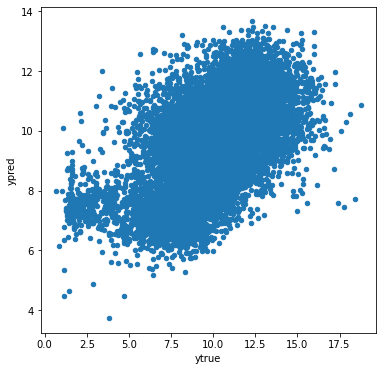

In [21]:
print(r2_score(df_eval2['ytrue'], df_eval2['ypred']))
df_eval2.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [22]:
df_eval2.to_csv('../output/oof_kronecker_epi_AD.csv', index=False)

In [23]:
!ls -lh ../output/oof_kronecker*

-rw-r--r-- 1 igorf samuelbf 839K Jan 31 19:25 ../output/oof_kronecker_additive.csv
-rw-r--r-- 1 igorf samuelbf 838K Jan 31 22:25 ../output/oof_kronecker_dominant.csv
-rw-r--r-- 1 igorf samuelbf 839K Feb  1 15:47 ../output/oof_kronecker_epi_AA.csv
-rw-r--r-- 1 igorf samuelbf 837K Feb  1 18:55 ../output/oof_kronecker_epi_AD.csv
-rw-r--r-- 1 igorf samuelbf 837K Feb  1 18:17 ../output/oof_kronecker_epi_DD.csv
